# Eye tracking: Decoding

## Overview
We trained a time-resolved linear decoder very comparable to the EEG decoder also on the eye tracking data. here we simply used the horizontal and vertical (here expressed as spherical angles) gaze coordinates as input features.  
We applied this procedure to decode mostly the same targets as from the EEG, to see how well this works on the eye tracking data.  

Please note: the actual decoding work was(/is better) done outside of this notebook (i.e., from the command line or better a HPC system). While it should theoretically also work from here, it is not tuned for performance (esp. in a notebook) and might take very long (hours to days) whereas when parallelized along the participant dimension. It only took ~30 minutes to run it on our HPC system. You can find the according slurm script `DECOD_ET.sh` in the `code\HPC` folder. 
  
The general idea is to have the decoding results saved into the `data` folder and then we read them out in this script to visualize and analyze them. 

Here is how to run the decoding from terminal (make sure to be in the root directory of the project and to have the proper conda environemnt activated)
```bash
python3.10 vr2f/code/vr2f/eyetracking/et_decoding.py 0 all
```
will run the decoding for the first (out of 17) participants and for all of the classifications which we investigated.  
If you want to run only the (multiclass) decoding of the emotional expressions you can run: 
```bash
python3.10 vr2f/code/vr2f/eyetracking/et_decoding.py 0 emotion
```
For the decoding of 2D vs 3D viewing conditions:
```bash
python3.10 vr2f/code/vr2f/eyetracking/et_decoding.py 0 viewcond
```
The index (first argument) refers to the (sorted) files in the preprocessed data folder (`data\eye_tracking\01_preproc`), so of you want to run it only for a specific participant, please go count the files. ;)

Once we have done this (or downloaded the data), we should hae all necessary folders and files in `data\eye_tracking\03_decoding` and load the for the visualizations here. 

In [13]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

import os
from collections import defaultdict
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from scipy import stats
from statsmodels.stats.anova import AnovaRM
from vr2f import helpers
from vr2f.staticinfo import COLORS, CONFIG, PATHS, TIMINGS


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [2]:
def load_decod_res_per_viewcond(
    sub_list_str,
    conditions,
    vc_list=[],
    scoring="roc_auc_ovr",
    modality="et",
):
    data_dict = dict()

    if len(vc_list) == 0:
        vc_list = [""]

    paths = PATHS()
    path_data = paths.DATA_ET_DECOD if modality == "et" else paths.DATA_04_DECOD_SENSORSPACE

    contrast_str = "_vs_".join(conditions)

    for vc in vc_list:
        data_dict[vc] = dict(scores=[], times=[])
        for subID in sub_list_str:
            fpath = Path(
                path_data,
                vc,
                contrast_str,
                scoring,
                "scores",
            )
            fname = Path(fpath, f"{subID}-scores_per_sub.npy")
            scores_ = np.load(fname)
            if modality == "et":
                scores_ = np.mean(scores_, axis=0) # average across CV folds
            data_dict[vc]["scores"].append(scores_)

            if len(data_dict[vc]["times"]) == 0:
                data_dict[vc]["times"] = np.load(str(fname)[:-4] + "__times" + ".npy")

        data_dict[vc]["scores"] = np.array(data_dict[vc]["scores"])

    return data_dict


def load_decod_res_per_contrast(
    sub_list_str,
    contrasts,
    scorings,
    vc_list=[],
    modality="et",
):
    data_dict = dict()

    if len(vc_list) == 0:
        vc_list = [""] * len(contrasts)
    elif len(vc_list) == 1:
        vc_list = vc_list * len(contrasts)
    elif len(vc_list) != len(contrasts):
        raise ValueError("vc_list must be same length as contrasts")

    if len(scorings) == 1:
        scorings = scorings * len(contrasts)
    elif len(scorings) != len(contrasts):
        raise ValueError("scorings must be same length as contrasts")

    paths = PATHS()
    path_data = paths.DATA_ET_DECOD if modality == "et" else paths.DATA_04_DECOD_SENSORSPACE

    contrast_str_list = ["_vs_".join(c) for c in contrasts]

    times = []
    for idx, c in enumerate(contrast_str_list):
        data_dict[c] = dict(scores=[], times=[])
        for subID in sub_list_str:
            fpath = Path(
                path_data,
                vc_list[idx],
                c,
                scorings[idx],
                "scores",
            )
            fname = Path(fpath, f"{subID}-scores_per_sub.npy")
            scores_ = np.load(fname)
            if modality == "et":
                scores_ = np.mean(scores_, axis=0) # average across CV folds
            data_dict[c]["scores"].append(scores_)

            if len(times) == 0:
                times = np.load(str(fname)[:-4] + "__times" + ".npy")
            data_dict[c]["times"] = times

        data_dict[c]["scores"] = np.array(data_dict[c]["scores"])

    return data_dict


def plot_score_per_factor(
    factor,
    data,
    scoring="accuracy",
    sign_clusters=[],
    p_lvl=0.05,
    chancelvl=0.5,
    ylims=None,
    xlims=None,
    ax=None,
    n_boot=1000,
    palette=None,
):
    if palette is None:
        colors = COLORS()
        palette = colors.COLDICT

    sns.lineplot(
        x="time",
        y="score",
        hue=factor,
        data=data,
        n_boot=n_boot,
        palette=palette,
        ax=ax,
        linewidth=1.5,
        legend=False,
        errorbar="se",
    )
    ytick_range = ax.get_ylim()
    if ylims is None:
        ylims = ytick_range
    ax.set(xlim=xlims, ylim=ylims)
    scoring_str = "ROC AUC" if scoring == "roc_auc" else scoring
    ax.set_ylabel(scoring_str)
    ax.set_xlabel("Time (s)")

    ax.text(x=1.0, y=chancelvl + 0.001, s="chance", ha="right")

    palette["diff"] = "red"

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.vlines(
        (0),
        ymin=ylims[0],
        ymax=ylims[1],
        linestyles="dashed",
        linewidth=0.5,
        color="black",
    )
    ax.hlines(
        chancelvl,
        xmin=xlims[0],
        xmax=xlims[1],
        linewidth=0.5,
        color="black",
    )
    p_lvl_str = "$p$ < ." + str(p_lvl).split(".")[-1]
    if isinstance(sign_clusters, dict):
        for i, key in enumerate(sign_clusters):
            col = palette[key.lower()]
            for sc in sign_clusters[key.lower()]:
                xmin = sc[0]
                xmax = sc[-1]
                y_ = ylims[0] + (0.04 - ((i + 1) * 0.025) * np.ptp(ylims))
                ax.hlines(
                    y_,
                    xmin=xmin,
                    xmax=xmax,
                    color=col,
                    label=p_lvl_str,
                )
            if i == 0 & len(sign_clusters[key.lower()]) > 0:
                ax.text(x=1.0, y=y_ + 0.001, s=p_lvl_str, ha="right")

    else:
        for sc in sign_clusters:
            xmin = sc[0]
            xmax = sc[-1]
            y_ = ytick_range[0] + 0.05 * np.ptp(ytick_range)
            ax.hlines(
                y_,
                xmin=xmin,
                xmax=xmax,
                color="purple",
                label=p_lvl_str,
            )
        if len(sign_clusters) > 0:
            ax.text(x=1.0, y=y_ + 0.001, s=p_lvl_str, ha="right")

    handles, labels = ax.get_legend_handles_labels()
    n_sgn_clu = None if len(sign_clusters) <= 1 else -(len(sign_clusters))
    # ax.legend(handles=handles[1:n_sgn_clu+1], labels=labels[1:n_sgn_clu+1])


def run_cbp_test(data, tail=0, nperm=10000):
    # number of permutations to run
    n_permutations = nperm
    # set initial threshold
    p_initial = 0.05
    # set family-wise p-value
    p_thresh = 0.05
    connectivity = None
    tail = tail  # 1 or -1 for one-sided test, 0 for two-sided

    config = CONFIG()

    # set cluster threshold
    n_samples = len(data)
    threshold = -stats.t.ppf(p_initial / (1 + (tail == 0)), n_samples - 1)
    if np.sign(tail) < 0:
        threshold = -threshold

    cluster_stats = mne.stats.permutation_cluster_1samp_test(
        data,
        threshold=threshold,
        n_jobs=5, # config.N_JOBS,
        verbose=False,
        tail=tail,
        step_down_p=0.0005,
        adjacency=connectivity,
        n_permutations=n_permutations,
        seed=42,
        out_type="mask",
    )

    T_obs, clusters, cluster_p_values, _ = cluster_stats
    return T_obs, clusters, cluster_p_values


def prep_and_plot_from_data(
    data_dict, subsets, ax, chancelvl=0.25, ylims=(0.2, 0.32), scoring="roc_auc", palette=None
):
    # Prepare data for plotting with seaborn:
    results_df_list = list()
    for vc in subsets:
        times = data_dict[vc]["times"]
        acc = np.asarray(data_dict[vc]["scores"])
        acc_df = pd.DataFrame(acc)
        acc_df.columns = times
        df = acc_df.melt(var_name="time", value_name="score")  # put into long format
        df["vc"] = vc
        results_df_list.append(df)
    data_plot = pd.concat(results_df_list)

    sign_cluster_times = {}
    # run CBP to find differences from chance:
    for vc in subsets:
        data = np.asarray(data_dict[vc]["scores"]) - chancelvl
        t_values, clusters, p_values = run_cbp_test(data, tail=1, nperm=10000)
        idx_sign_clusters = np.argwhere(p_values < p_val_cbp)
        sign_cluster_times[vc] = [times[clusters[idx[0]]][[0, -1]] for idx in idx_sign_clusters]
        print(f"Found {len(sign_cluster_times[vc])} significant clusters for viewing condition '{vc}'.")
        for i in range(len(sign_cluster_times[vc])):
            print(f"Significant cluster: {sign_cluster_times[vc][i][0]:.3f} - {sign_cluster_times[vc][i][1]:.3f}")
    if len(subsets) == 2:
        # run CBP to find difference between conditions:
        data = np.asarray(data_dict[subsets[0]]["scores"]) - np.asarray(data_dict[subsets[1]]["scores"])
        t_values, clusters, p_values = run_cbp_test(data, tail=0, nperm=10000)
        idx_sign_clusters = np.argwhere(p_values < p_val_cbp)
        sign_cluster_times["diff"] = [times[clusters[idx[0]]][[0, -1]] for idx in idx_sign_clusters]
        if len(sign_cluster_times["diff"]) > 0:
            helpers.print_msg(f"Found {len(idx_sign_clusters)} significant difference between conditions! Do you see that?")
    else:
        sign_cluster_times["diff"] = []
        print(
            "Not checking for difference between conditions (only implemented for 2 groups)."
        )

    # Plot it:

    plot_score_per_factor(
        factor="vc",
        data=data_plot.reset_index(),
        scoring=scoring,
        sign_clusters={ecc: sign_cluster_times[ecc] for ecc in subsets + ["diff"]},
        p_lvl=p_val_cbp,
        chancelvl=chancelvl,
        ylims=ylims,
        xlims=(-0.3, 1.0),
        n_boot=1000,
        palette=palette,
        ax=ax,
    )
    ax.set_ylabel("ROC-AUC" if "roc_auc" in scoring else scoring)

def resample_et(data_dict_et, times_eeg):
  data_resampled = defaultdict(dict)
  for vc in data_dict_et:
    df_et = pd.DataFrame(data_dict_et[vc]["scores"].T)
    df_et.index = data_dict_et[vc]["times"]

    df_et = df_et.reindex(df_et.index.union(times_eeg))
    df_et = df_et.interpolate(method='index').reindex(times_eeg)

    data_resampled[vc]["scores"] = df_et.T.to_numpy()
    data_resampled[vc]["times"] = times_eeg
  return data_resampled

## Setup 

### Parameters
Set some parameters for plotting

In [3]:
# Setup:
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams.update({"font.size": 16})
cm = 1 / 2.54  # inch to cm

# p-value for the CBP test
p_val_cbp = 0.05


## Load decoding results from disc

In [4]:
paths = PATHS()
path_in = Path(
    paths.DATA_ET_DECOD, "mono", "neutral_vs_happy_vs_angry_vs_surprised", "roc_auc_ovr", "scores"
)

sub_list_str = [s.split("-scores")[0] for s in os.listdir(path_in)]
sub_list_str = np.unique(sorted(sub_list_str))

data_dict_allemos = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["neutral", "happy", "angry", "surprised"],
    vc_list=["mono", "stereo", ""],  # we do not differentiate the viewing conditons here
    scoring="roc_auc_ovr",
    modality="et",
)
data_dict_allemos["all"] = data_dict_allemos.pop("")


This now gives us a dictionnary from which we can draw the relevant data for visualization. We create a second, more detailled one:

In [5]:
cond_dict = {
    "viewcond": {1: "mono", 2: "stereo"},
    "emotion": {1: "neutral", 2: "happy", 3: "angry", 4: "surprised"},
    "avatar_id": {1: "id1", 2: "id2", 3: "id3"},
}

contrasts = [
    ["neutral", "happy", "angry", "surprised"],
    ["angry", "neutral"],
    ["happy", "neutral"],
    ["surprised", "neutral"],
    ["angry", "happy"],
    ["angry", "surprised"],
    ["happy", "surprised"],
    ["mono", "stereo"],
    ["id1", "id2", "id3"],
]

data_dict_allcontrasts_et = load_decod_res_per_contrast(
    sub_list_str=sub_list_str,
    contrasts=contrasts,
    scorings=["roc_auc_ovr"] * len(contrasts),
    modality="et",
)

data_dict_allcontrasts_et["all"] = data_dict_allcontrasts_et.pop("neutral_vs_happy_vs_angry_vs_surprised")

contrasts_str_list = ["_vs_".join([c.lower() for c in contr]) for contr in contrasts]
colors = COLORS()
colors_custom = [colors.COLDICT[c] for c in contrasts_str_list]
# ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
palette = {contr: colors_custom[i] for i, contr in enumerate(contrasts_str_list)}




## Plotting: multiclass decoding of emotional expressions

We plot the time-resolved decoding for the classification of the 4 different emotional expressions. Chance level is at 0.5 as our scorer for the classification performance is ROC AUC (which is 0.5 at chance), set up as a "one-vs-rest" problem for evaluating the results (for details see [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#one-vs-rest-multiclass-roc)).  
The horizontal line at the bottom visualizes the result from a CBP test (i.e., it indicates a "significant cluster" for which the decoding performance was significantly higher than chance level). 

Found 1 significant clusters for viewing condition 'all'.
Significant cluster: 0.233 - 1.100
Not checking for difference between conditions (only implemented for 2 groups).


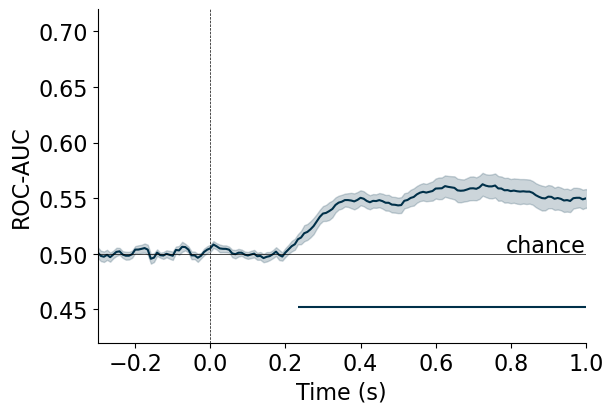

In [25]:
fig, ax = plt.subplots(1, figsize=(16 * cm, 11 * cm))
prep_and_plot_from_data(
    data_dict_allemos, subsets=["all"], ax=ax, chancelvl=0.5, ylims=(0.42, 0.72), scoring="roc_auc_ovr"
)

Found 1 significant clusters for viewing condition 'mono'.
Significant cluster: 0.217 - 1.100
Found 1 significant clusters for viewing condition 'stereo'.
Significant cluster: 0.267 - 1.100


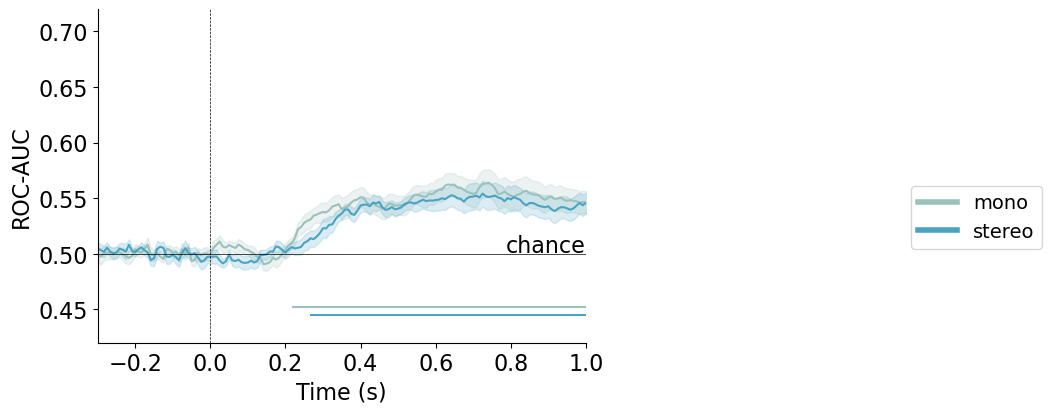

In [35]:
fig, ax = plt.subplots(1, figsize=(16 * cm, 11 * cm))
prep_and_plot_from_data(
    data_dict_allemos, subsets=["mono", "stereo"], ax=ax, chancelvl=0.5, ylims=(0.42, 0.72), scoring="roc_auc_ovr"
)
# add custom legend using palette and place it outside of the plot:
legend_elements = [Line2D([0], [0], color=colors.COLDICT[contr], lw=4, label=contr) for contr in ["mono", "stereo"]]
ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(1.8, 0.5), ncol=1, fontsize=14)

## Plotting: selected binary contrasts (emo. expressions) and multiclass decoding

Found 1 significant clusters for viewing condition 'neutral_vs_happy_vs_angry_vs_surprised'.
Significant cluster: 0.233 - 1.100
Found 1 significant clusters for viewing condition 'angry_vs_neutral'.
Significant cluster: 0.250 - 1.100
Found 3 significant clusters for viewing condition 'happy_vs_neutral'.
Significant cluster: 0.008 - 0.058
Significant cluster: 0.267 - 0.325
Significant cluster: 0.367 - 1.100
Found 1 significant clusters for viewing condition 'surprised_vs_neutral'.
Significant cluster: 0.233 - 1.100
Found 1 significant clusters for viewing condition 'angry_vs_happy'.
Significant cluster: 0.258 - 1.100
Found 1 significant clusters for viewing condition 'angry_vs_surprised'.
Significant cluster: 0.458 - 1.100
Found 1 significant clusters for viewing condition 'happy_vs_surprised'.
Significant cluster: 0.233 - 1.100
Found 0 significant clusters for viewing condition 'mono_vs_stereo'.
Found 1 significant clusters for viewing condition 'woman_01_vs_woman_04_vs_woman_08'.
Sign

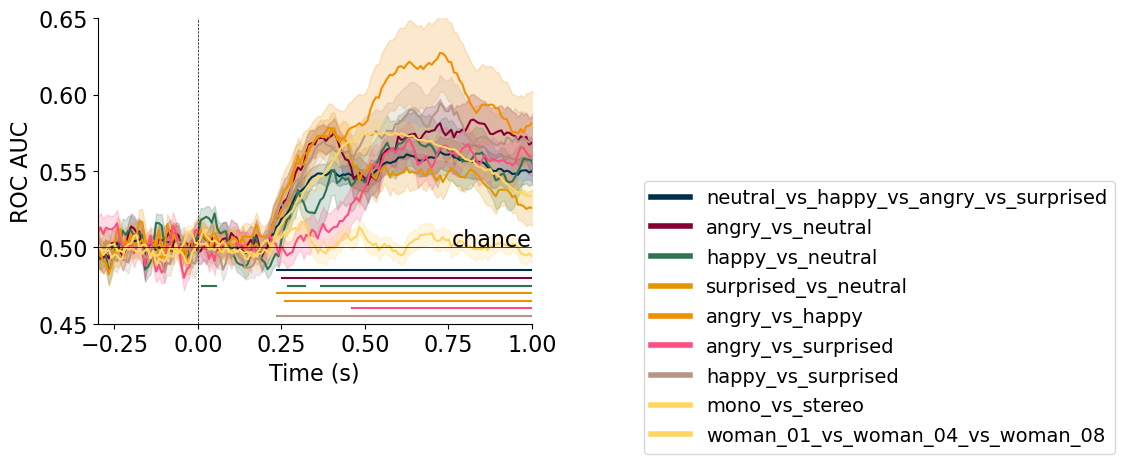

In [87]:
fig, ax = plt.subplots(1, figsize=(14.2328 * cm, 10.0786 * cm))
prep_and_plot_from_data(
    data_dict_allcontrasts_et,
    subsets=contrasts_str_list,
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.65),
    scoring="roc_auc",
    palette=palette,
)
# add custom legend using palette and place it outside of the plot:
legend_elements = [Line2D([0], [0], color=palette[contr], lw=4, label=contr) for contr in contrasts_str_list]
ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(1.8, 0.5), ncol=1, fontsize=14)


# save:
fig.savefig(
    Path(paths.FIGURES, "decod_et_allcontrasts.pdf"),
    dpi=300,
    # bbox_inches="tight",
)

Found 1 significant clusters for viewing condition 'angry_vs_neutral'.
Significant cluster: 0.250 - 1.100
Not checking for difference between conditions (only implemented for 2 groups).


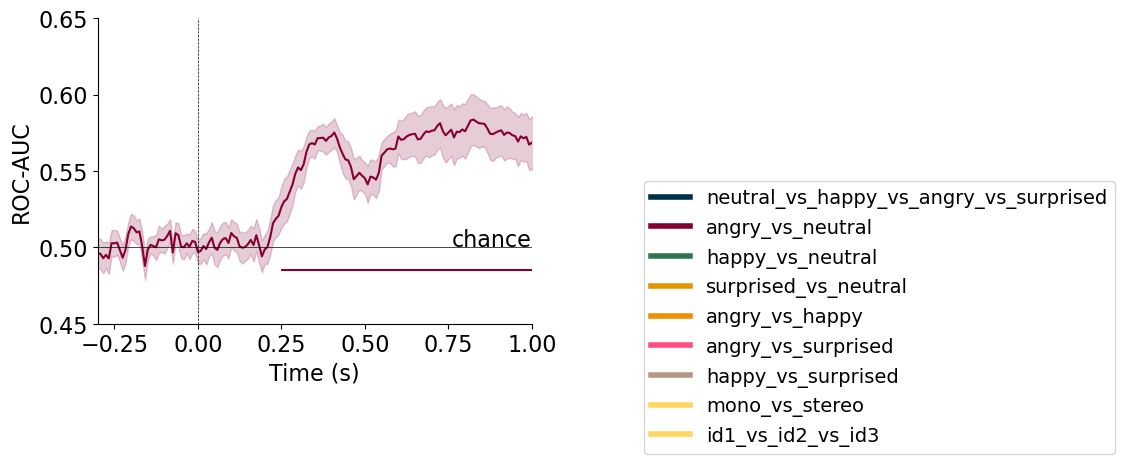

In [41]:
fig, ax = plt.subplots(1, figsize=(14.2328 * cm, 10.0786 * cm))
prep_and_plot_from_data(
    data_dict_allcontrasts_et,
    subsets=["angry_vs_neutral"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.65),
    scoring="roc_auc",
    palette=palette,
)
# add custom legend using palette and place it outside of the plot:
legend_elements = [Line2D([0], [0], color=palette[contr], lw=4, label=contr) for contr in contrasts_str_list]
ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(1.8, 0.5), ncol=1, fontsize=14)

Found 3 significant clusters for viewing condition 'happy_vs_neutral'.
Significant cluster: 0.008 - 0.058
Significant cluster: 0.267 - 0.325
Significant cluster: 0.367 - 1.100
Not checking for difference between conditions (only implemented for 2 groups).


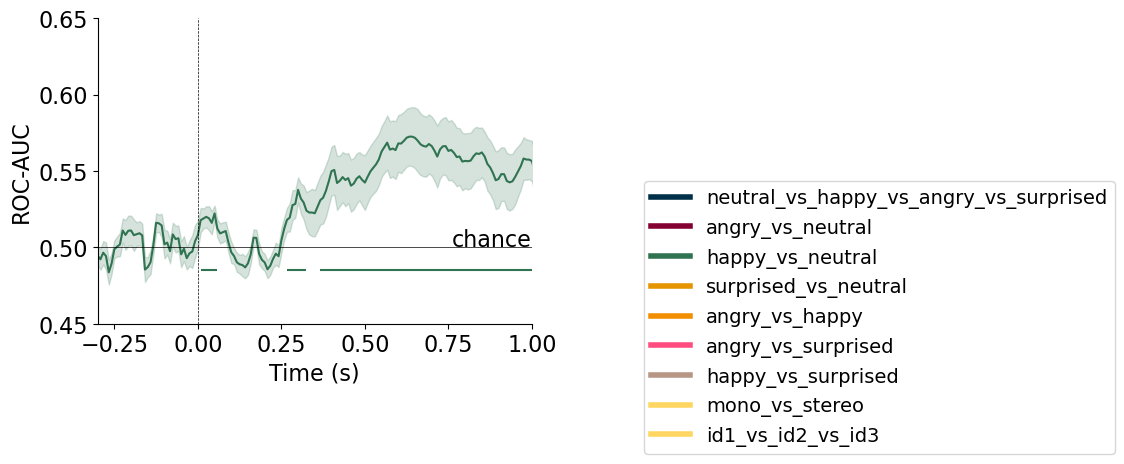

In [42]:
fig, ax = plt.subplots(1, figsize=(14.2328 * cm, 10.0786 * cm))
prep_and_plot_from_data(
    data_dict_allcontrasts_et,
    subsets=["happy_vs_neutral"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.65),
    scoring="roc_auc",
    palette=palette,
)
# add custom legend using palette and place it outside of the plot:
legend_elements = [Line2D([0], [0], color=palette[contr], lw=4, label=contr) for contr in contrasts_str_list]
ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(1.8, 0.5), ncol=1, fontsize=14)

Found 1 significant clusters for viewing condition 'angry_vs_surprised'.
Significant cluster: 0.458 - 1.100
Not checking for difference between conditions (only implemented for 2 groups).


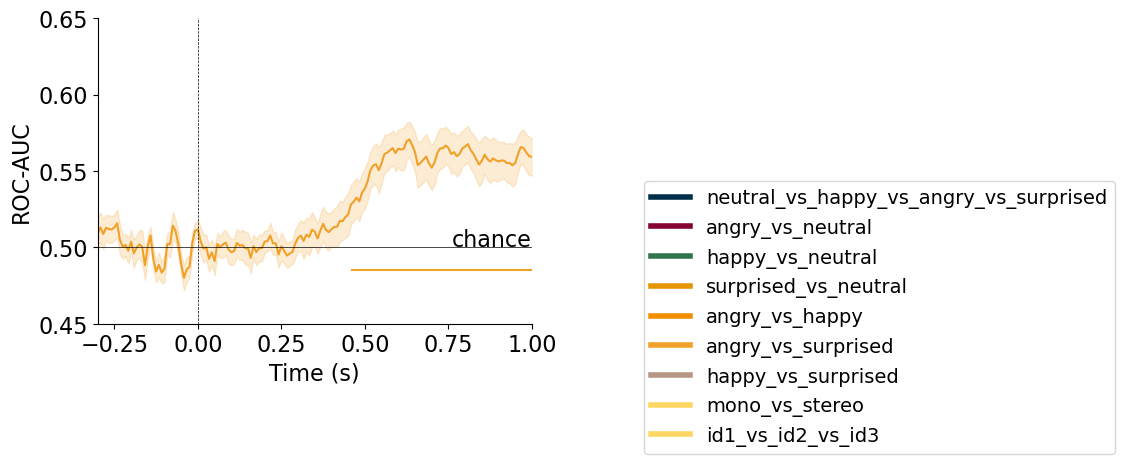

In [47]:
fig, ax = plt.subplots(1, figsize=(14.2328 * cm, 10.0786 * cm))
prep_and_plot_from_data(
    data_dict_allcontrasts_et,
    subsets=["angry_vs_surprised"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.65),
    scoring="roc_auc",
    palette=palette,
)
# add custom legend using palette and place it outside of the plot:
legend_elements = [Line2D([0], [0], color=palette[contr], lw=4, label=contr) for contr in contrasts_str_list]
ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(1.8, 0.5), ncol=1, fontsize=14)

Found 0 significant clusters for viewing condition 'mono_vs_stereo'.
Found 1 significant clusters for viewing condition 'id1_vs_id2_vs_id3'.
Significant cluster: 0.242 - 1.100

#######################################################################################
Found 1 significant difference between conditions! Do you see that?
#######################################################################################



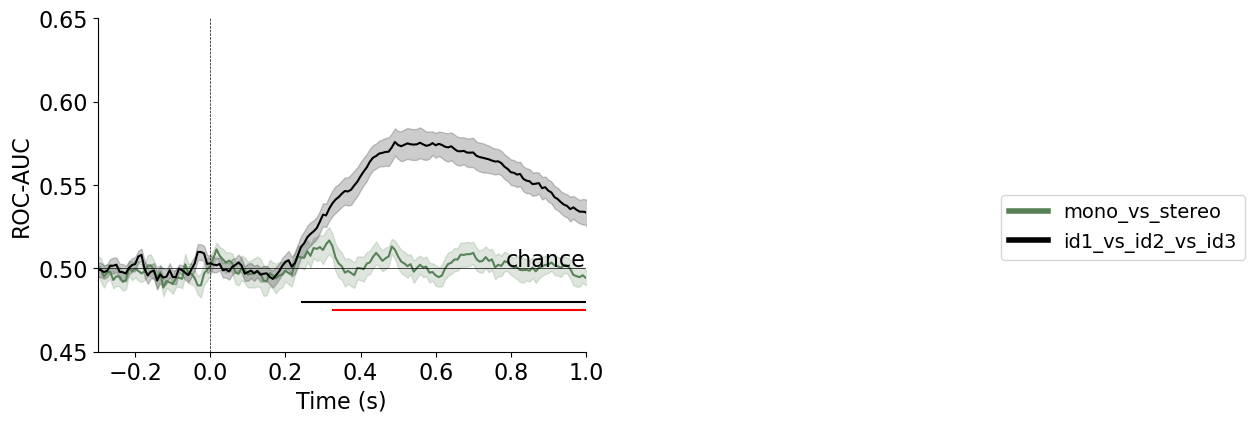

In [37]:
contrasts = [
    ["mono", "stereo"],
    [ava_id.lower() for ava_id in cond_dict["avatar_id"].values()],
]
data_dict_taskirr_contrasts = load_decod_res_per_contrast(
    sub_list_str=sub_list_str,
    contrasts=contrasts,
    scorings=[
        "roc_auc_ovr",
    ],
)

contrasts_str_list = ["_vs_".join([c.lower() for c in contr]) for contr in contrasts]
colors = COLORS()
colors_custom = [colors.COLDICT["viewcond"], "black"]
palette = {contr: colors_custom[i] for i, contr in enumerate(contrasts_str_list)}


fig, ax = plt.subplots(1, figsize=(16*cm, 11*cm)) # figsize=(8.7152 * cm, 6.1993 * cm))
prep_and_plot_from_data(
    data_dict_taskirr_contrasts,
    subsets=contrasts_str_list,
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.65),
    scoring="roc_auc",
    palette=palette,
)

# add custom legend using palette and place it outside of the plot:
legend_elements = [Line2D([0], [0], color=palette[contr], lw=4, label=contr) for contr in contrasts_str_list]
ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(2.1, 0.5), ncol=1, fontsize=14)


# save:
fig.savefig(
    Path(paths.FIGURES, "decod_et_taskirr_contrasts.pdf"),
    dpi=300,
    # bbox_inches="tight",
)

## Compare ET decoding with EEG decoding results

In [48]:
data_dict_allemos_eeg = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["neutral", "happy", "angry", "surprised"],
    vc_list=["mono", "stereo", ""],  # we do not differentiate the viewing conditons here
    scoring="roc_auc_ovr",
    modality="eeg",
)
data_dict_allemos_eeg["all"] = data_dict_allemos_eeg.pop("")


contrasts = [
    ["neutral", "happy", "angry", "surprised"],
    ["angry", "neutral"],
    ["happy", "neutral"],
    ["surprised", "neutral"],
    ["angry", "happy"],
    ["angry", "surprised"],
    ["happy", "surprised"],
    ["id1", "id2", "id3"],
    ["mono", "stereo"]
]
data_dict_allcontrasts_eeg = load_decod_res_per_contrast(
    sub_list_str=sub_list_str,
    contrasts=contrasts,
    scorings=["roc_auc_ovr"] * len(contrasts),
    modality="eeg",
)
data_dict_allcontrasts_eeg["all"] = data_dict_allcontrasts_eeg.pop("neutral_vs_happy_vs_angry_vs_surprised")

times_eeg = data_dict_allcontrasts_eeg["happy_vs_neutral"]["times"]
data_dict_allcontrasts_et = resample_et(data_dict_allcontrasts_et, times_eeg)

Found 1 significant clusters for viewing condition 'et'.
Significant cluster: 0.234 - 1.000
Found 1 significant clusters for viewing condition 'eeg'.
Significant cluster: 0.094 - 1.000

#######################################################################################
Found 1 significant difference between conditions! Do you see that?
#######################################################################################



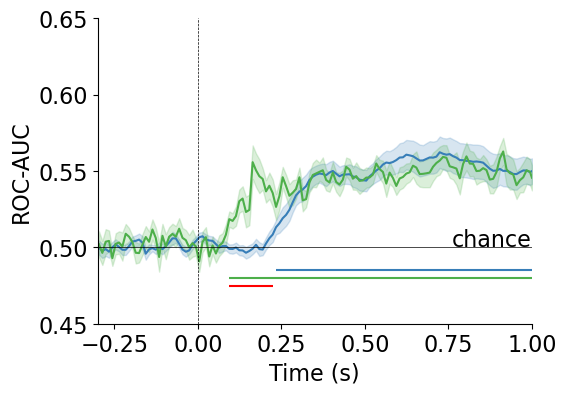

In [65]:
data_dict_et_eeg = {}
data_dict_et_eeg["et"] = data_dict_allcontrasts_et["all"]
data_dict_et_eeg["eeg"] = data_dict_allemos_eeg["all"]
palette["et"] = "#377eb8"
palette["eeg"] = "#4daf4a"


fig, ax = plt.subplots(1, figsize=(14.2328 * cm, 10.0786 * cm))  # figsize=(8.7152 * cm, 6.1993 * cm))
prep_and_plot_from_data(
    data_dict_et_eeg,
    subsets=["et", "eeg"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.65),
    scoring="roc_auc",
    palette=palette,
)

Found 1 significant clusters for viewing condition 'et'.
Significant cluster: 0.244 - 1.000
Found 1 significant clusters for viewing condition 'eeg'.
Significant cluster: 0.124 - 1.000

#######################################################################################
Found 1 significant difference between conditions! Do you see that?
#######################################################################################



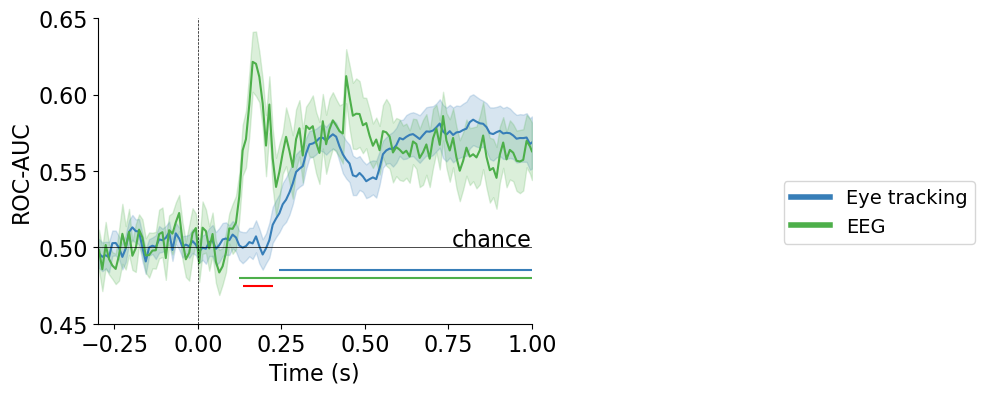

In [67]:
data_dict_et_eeg = {}
data_dict_et_eeg["et"] = data_dict_allcontrasts_et["angry_vs_neutral"]
data_dict_et_eeg["eeg"] = data_dict_allcontrasts_eeg["angry_vs_neutral"]
palette["et"] = "#377eb8"
palette["eeg"] = "#4daf4a"

fig, ax = plt.subplots(1, figsize=(14.2328 * cm, 10.0786 * cm))  # figsize=(8.7152 * cm, 6.1993 * cm))
prep_and_plot_from_data(
    data_dict_et_eeg,
    subsets=["et", "eeg"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.65),
    scoring="roc_auc",
    palette=palette,
)

# add custom legend using palette and place it outside of the plot:
labels = {'et': 'Eye tracking', 'eeg': 'EEG'}
legend_elements = [Line2D([0], [0], color=palette[contr], lw=4, label=labels[contr]) for contr in ["et", "eeg"]]
ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(1.8, 0.5), ncol=2, fontsize=14)

Found 1 significant clusters for viewing condition 'et'.
Significant cluster: 0.364 - 1.000
Found 4 significant clusters for viewing condition 'eeg'.
Significant cluster: 0.104 - 0.134
Significant cluster: 0.174 - 0.214
Significant cluster: 0.334 - 0.454
Significant cluster: 0.484 - 1.000


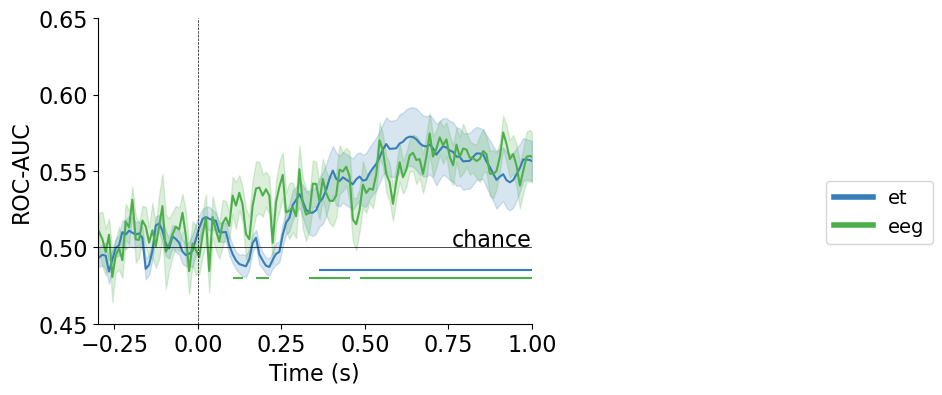

In [56]:
data_dict_et_eeg = {}
data_dict_et_eeg["et"] = data_dict_allcontrasts_et["happy_vs_neutral"]
data_dict_et_eeg["eeg"] = data_dict_allcontrasts_eeg["happy_vs_neutral"]
palette["et"] = "#377eb8"
palette["eeg"] = "#4daf4a"

fig, ax = plt.subplots(1, figsize=(14.2328 * cm, 10.0786 * cm))  # figsize=(8.7152 * cm, 6.1993 * cm))
prep_and_plot_from_data(
    data_dict_et_eeg,
    subsets=["et", "eeg"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.65),
    scoring="roc_auc",
    palette=palette,
)

# add custom legend using palette and place it outside of the plot:
legend_elements = [Line2D([0], [0], color=palette[contr], lw=4, label=contr) for contr in ["et", "eeg"]]
ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(1.8, 0.5), ncol=1, fontsize=14)

Found 1 significant clusters for viewing condition 'et'.
Significant cluster: 0.454 - 1.000
Found 2 significant clusters for viewing condition 'eeg'.
Significant cluster: 0.714 - 0.774
Significant cluster: 0.804 - 0.914

#######################################################################################
Found 1 significant difference between conditions! Do you see that?
#######################################################################################



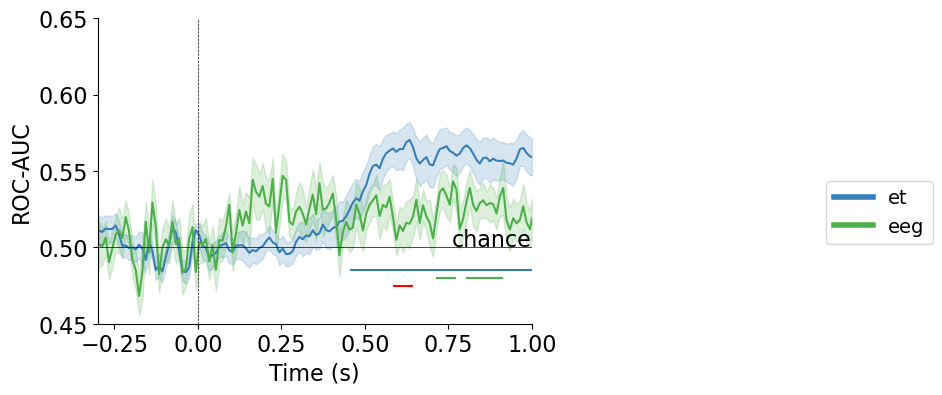

In [57]:
data_dict_et_eeg = {}
data_dict_et_eeg["et"] = data_dict_allcontrasts_et["angry_vs_surprised"]
data_dict_et_eeg["eeg"] = data_dict_allcontrasts_eeg["angry_vs_surprised"]
palette["et"] = "#377eb8"
palette["eeg"] = "#4daf4a"

fig, ax = plt.subplots(1, figsize=(14.2328 * cm, 10.0786 * cm))  # figsize=(8.7152 * cm, 6.1993 * cm))
prep_and_plot_from_data(
    data_dict_et_eeg,
    subsets=["et", "eeg"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.65),
    scoring="roc_auc",
    palette=palette,
)

# add custom legend using palette and place it outside of the plot:
legend_elements = [Line2D([0], [0], color=palette[contr], lw=4, label=contr) for contr in ["et", "eeg"]]
ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(1.8, 0.5), ncol=1, fontsize=14)

Found 0 significant clusters for viewing condition 'et'.
Found 1 significant clusters for viewing condition 'eeg'.
Significant cluster: 0.114 - 0.584

#######################################################################################
Found 2 significant difference between conditions! Do you see that?
#######################################################################################



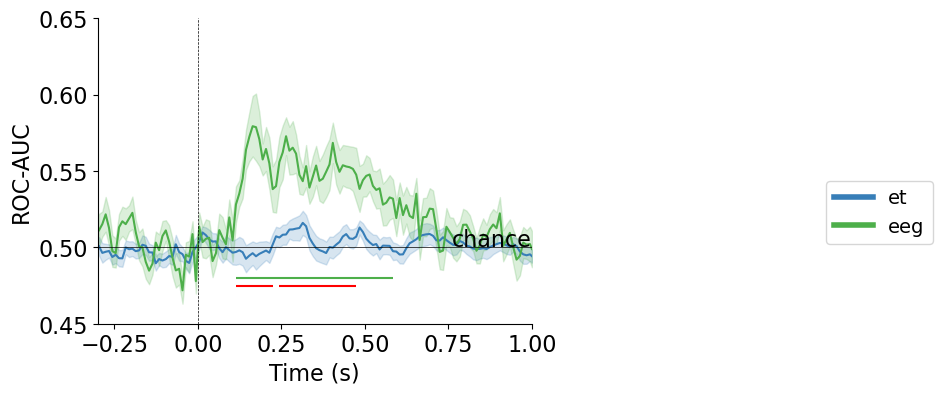

In [68]:
data_dict_et_eeg = {}
data_dict_et_eeg["et"] = data_dict_allcontrasts_et["mono_vs_stereo"]
data_dict_et_eeg["eeg"] = data_dict_allcontrasts_eeg["mono_vs_stereo"]
palette["et"] = "#377eb8"
palette["eeg"] = "#4daf4a"

fig, ax = plt.subplots(1, figsize=(14.2328 * cm, 10.0786 * cm))  # figsize=(8.7152 * cm, 6.1993 * cm))
prep_and_plot_from_data(
    data_dict_et_eeg,
    subsets=["et", "eeg"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.65),
    scoring="roc_auc",
    palette=palette,
)

# add custom legend using palette and place it outside of the plot:
legend_elements = [Line2D([0], [0], color=palette[contr], lw=4, label=contr) for contr in ["et", "eeg"]]
ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(1.8, 0.5), ncol=1, fontsize=14)

Found 1 significant clusters for viewing condition 'et'.
Significant cluster: 0.244 - 1.000
Found 2 significant clusters for viewing condition 'eeg'.
Significant cluster: 0.094 - 0.144
Significant cluster: 0.414 - 0.484

#######################################################################################
Found 2 significant difference between conditions! Do you see that?
#######################################################################################



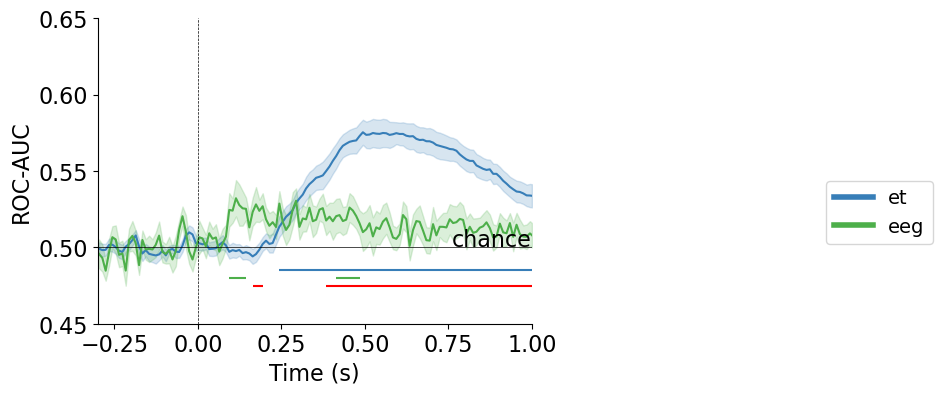

In [69]:
data_dict_et_eeg = {}
data_dict_et_eeg["et"] = data_dict_allcontrasts_et["id1_vs_id2_vs_id3"]
data_dict_et_eeg["eeg"] = data_dict_allcontrasts_eeg["id1_vs_id2_vs_id3"]
palette["et"] = "#377eb8"
palette["eeg"] = "#4daf4a"

fig, ax = plt.subplots(1, figsize=(14.2328 * cm, 10.0786 * cm))  # figsize=(8.7152 * cm, 6.1993 * cm))
prep_and_plot_from_data(
    data_dict_et_eeg,
    subsets=["et", "eeg"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.65),
    scoring="roc_auc",
    palette=palette,
)

# add custom legend using palette and place it outside of the plot:
legend_elements = [Line2D([0], [0], color=palette[contr], lw=4, label=contr) for contr in ["et", "eeg"]]
ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(1.8, 0.5), ncol=1, fontsize=14)

Found 1 significant clusters for viewing condition 'et'.
Significant cluster: 0.244 - 1.000
Found 1 significant clusters for viewing condition 'eeg'.
Significant cluster: 0.124 - 1.000

#######################################################################################
Found 1 significant difference between conditions! Do you see that?
#######################################################################################

Found 1 significant clusters for viewing condition 'et'.
Significant cluster: 0.364 - 1.000
Found 4 significant clusters for viewing condition 'eeg'.
Significant cluster: 0.104 - 0.134
Significant cluster: 0.174 - 0.214
Significant cluster: 0.334 - 0.454
Significant cluster: 0.484 - 1.000
Found 1 significant clusters for viewing condition 'et'.
Significant cluster: 0.234 - 1.000
Found 3 significant clusters for viewing condition 'eeg'.
Significant cluster: 0.194 - 0.254
Significant cluster: 0.274 - 0.304
Significant cluster: 0.324 - 1.000
Found 1 significant clus

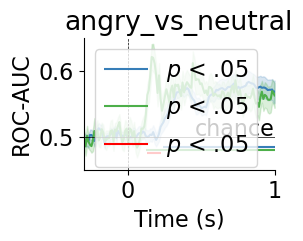

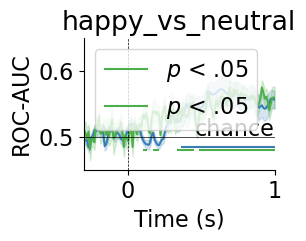

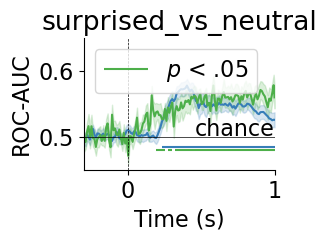

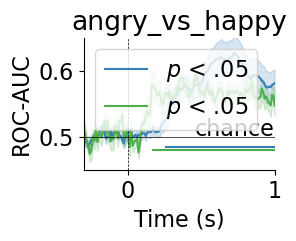

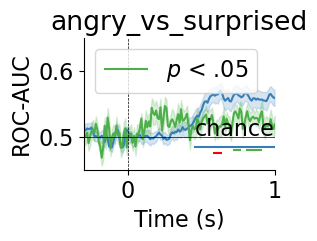

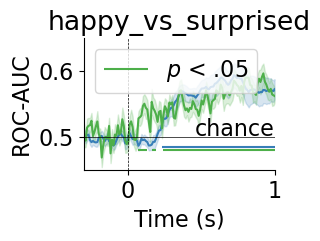

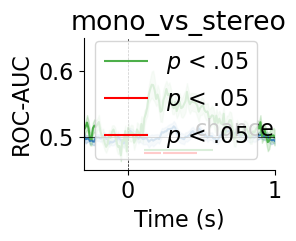

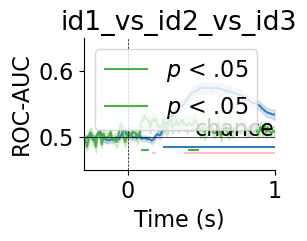

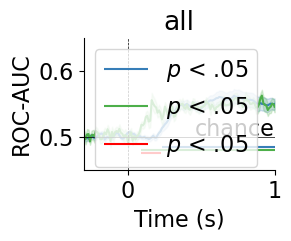

In [55]:

for idx, contrast in  enumerate(data_dict_allcontrasts_et):
    if contrast == "neutral_vs_happy_vs_angry_vs_surprised":
        contrast = "all"
    data_dict_et_eeg = {}
    data_dict_et_eeg["et"] = data_dict_allcontrasts_et[contrast]
    data_dict_et_eeg["eeg"] = data_dict_allcontrasts_eeg[contrast]
    palette["et"] = "#377eb8"
    palette["eeg"] = "#4daf4a"

    fig, ax = plt.subplots(1, figsize=(14.2328 * cm, 10.0786 * cm))  #figsize=(8.7152 * cm, 6.1993 * cm))
    prep_and_plot_from_data(
        data_dict_et_eeg,
        subsets=["et", "eeg"],
        ax=ax,
        chancelvl=0.5,
        ylims=(0.45, 0.65),
        scoring="roc_auc",
        palette=palette,
    )
    ax.set_title(contrast)

In [123]:
2+2

4

Correlation between Max scores scores of EEG and ET: -0.040, p = 0.878
Correlation between Mean scores scores of EEG and ET: -0.012, p = 0.965
Correlation between Time of max scores scores of EEG and ET: 0.035, p = 0.894
Correlation between Max scores scores of EEG and ET: 0.199, p = 0.443
Correlation between Mean scores scores of EEG and ET: 0.466, p = 0.059
Correlation between Time of max scores scores of EEG and ET: -0.263, p = 0.308
Correlation between Max scores scores of EEG and ET: 0.534, p = 0.027
Correlation between Mean scores scores of EEG and ET: 0.264, p = 0.306
Correlation between Time of max scores scores of EEG and ET: -0.585, p = 0.014
Correlation between Max scores scores of EEG and ET: -0.197, p = 0.450
Correlation between Mean scores scores of EEG and ET: -0.186, p = 0.474
Correlation between Time of max scores scores of EEG and ET: 0.135, p = 0.606
Correlation between Max scores scores of EEG and ET: -0.242, p = 0.349
Correlation between Mean scores scores of EEG a

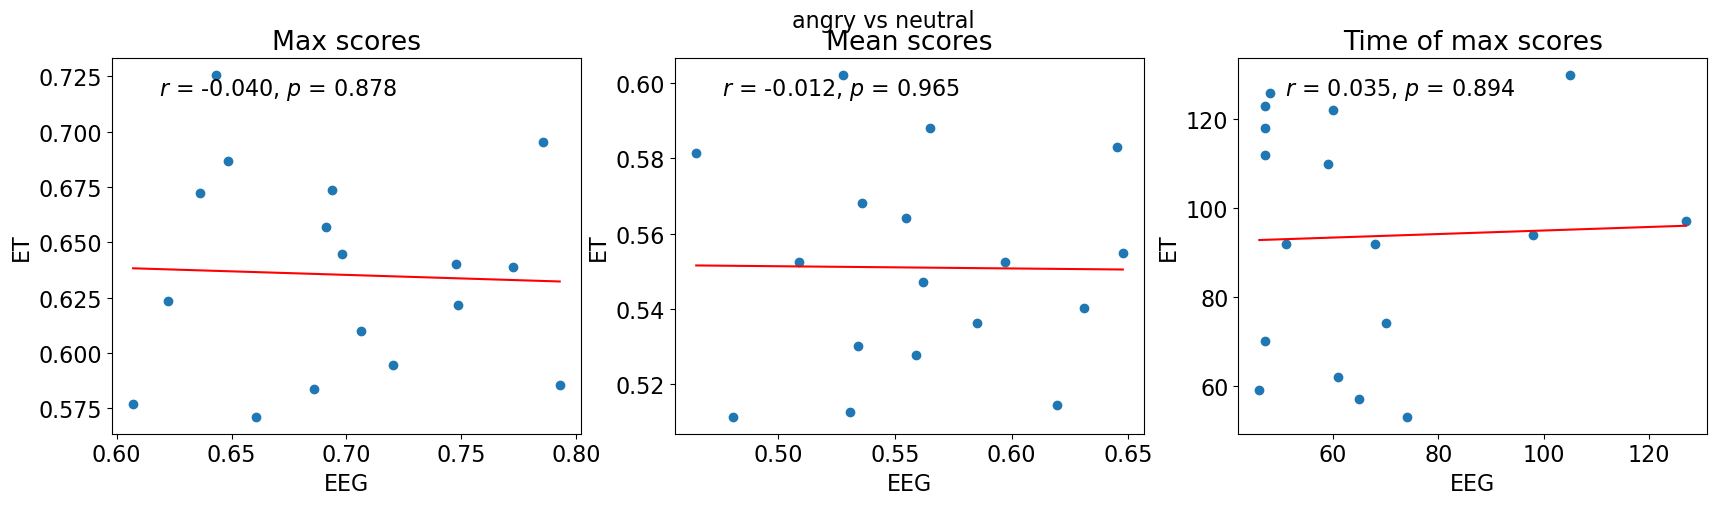

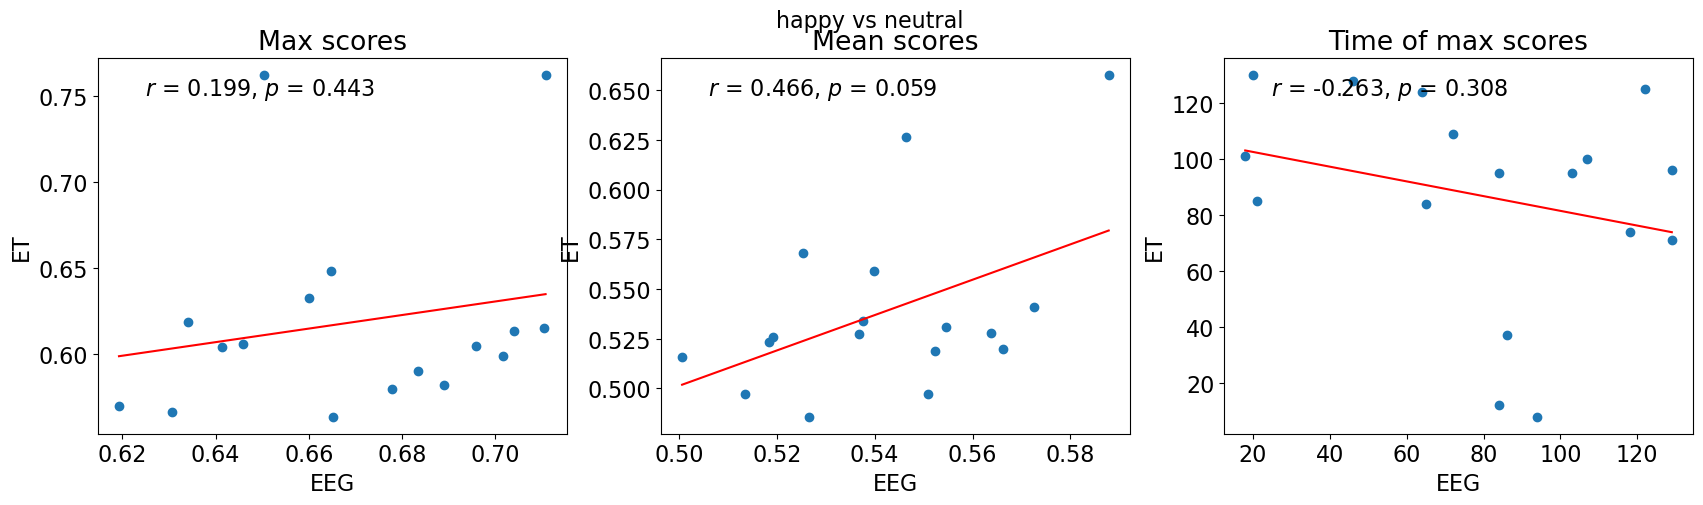

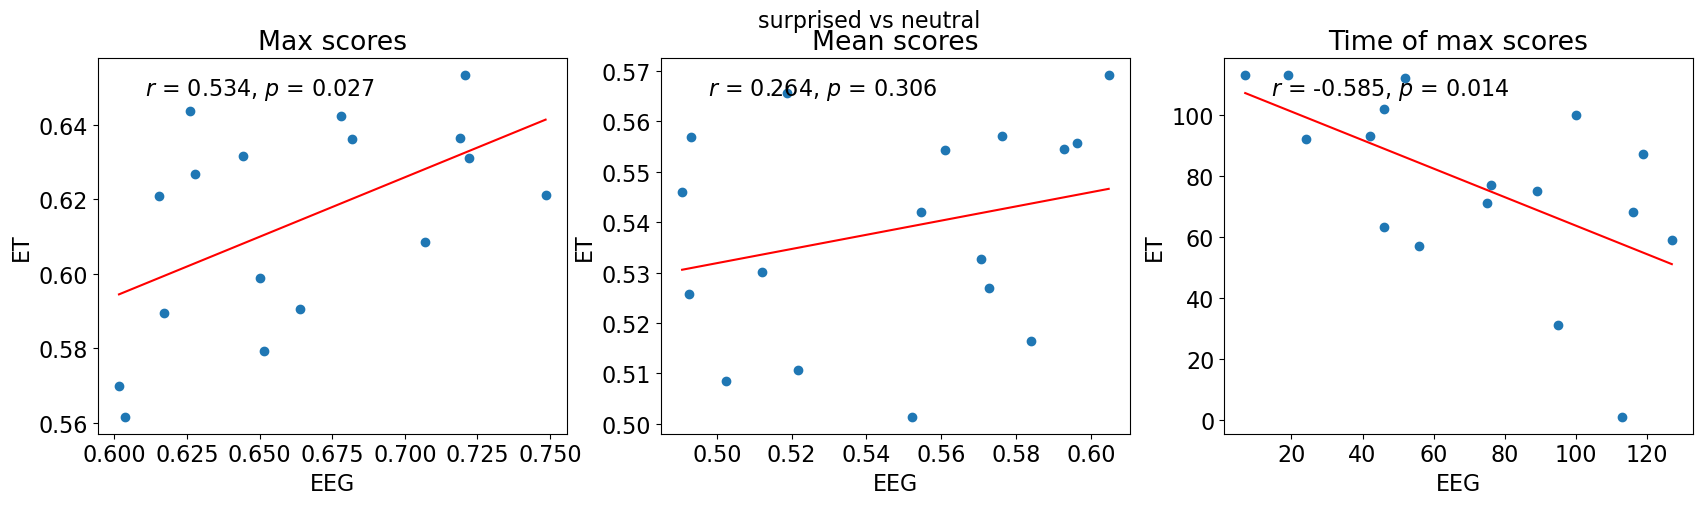

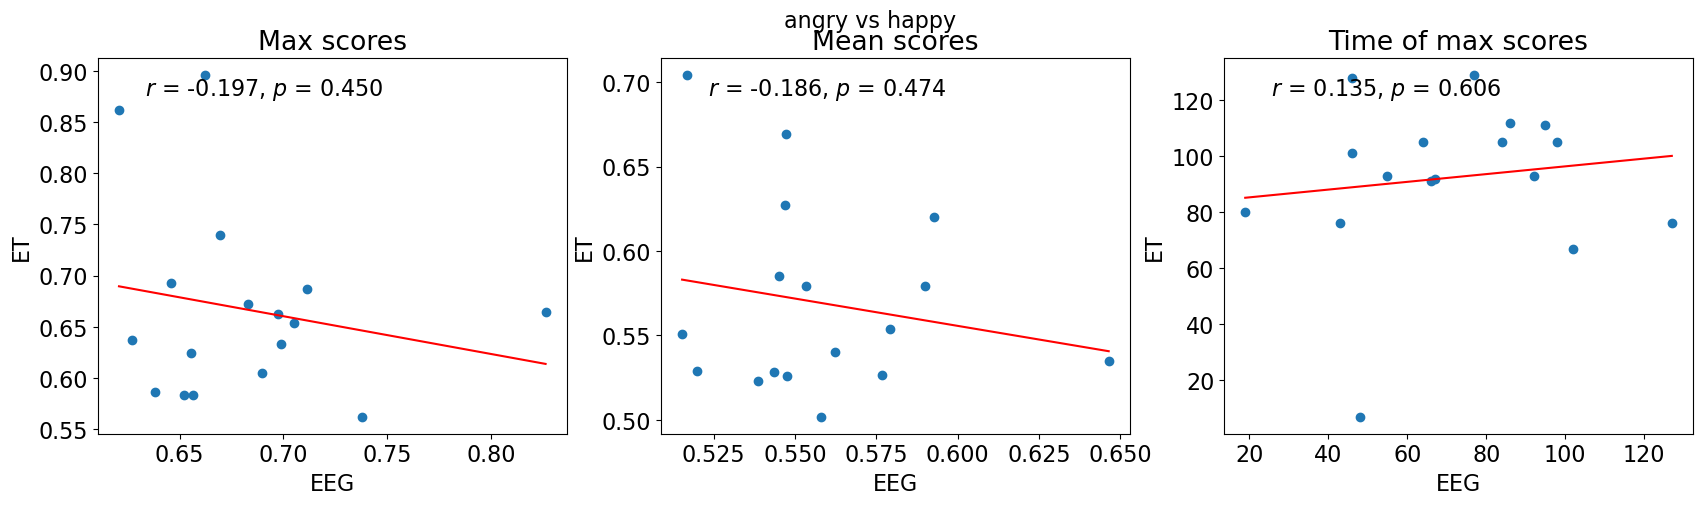

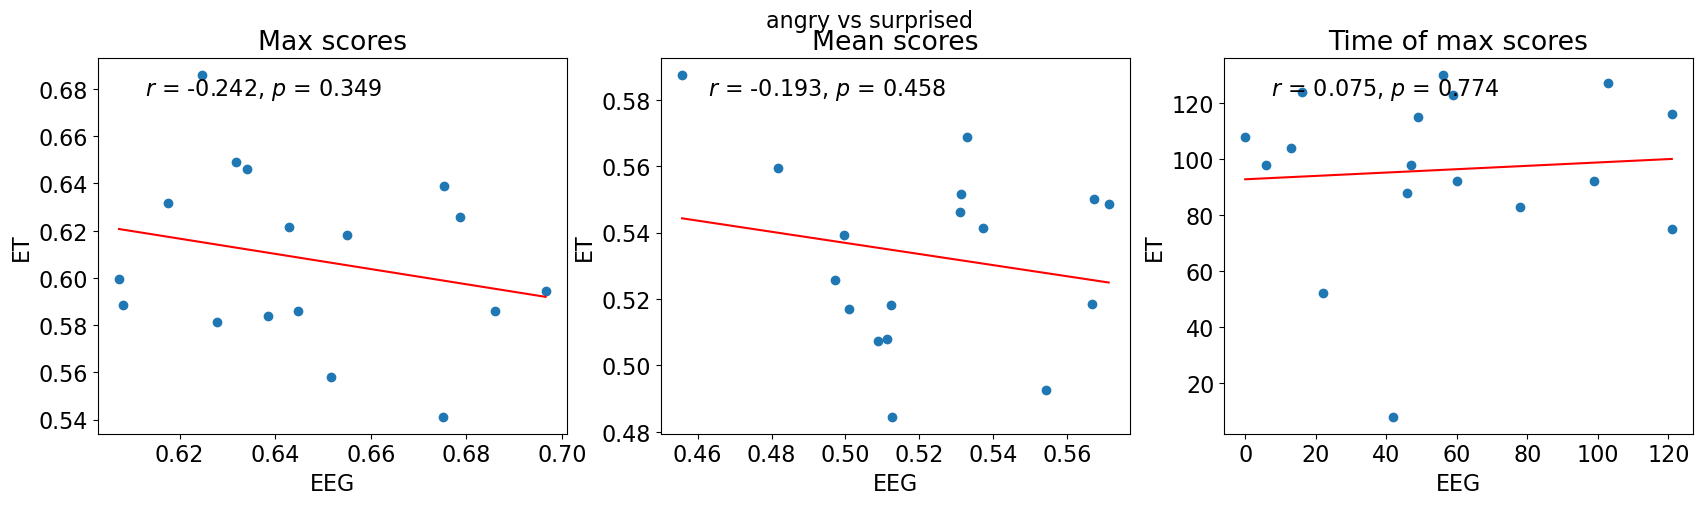

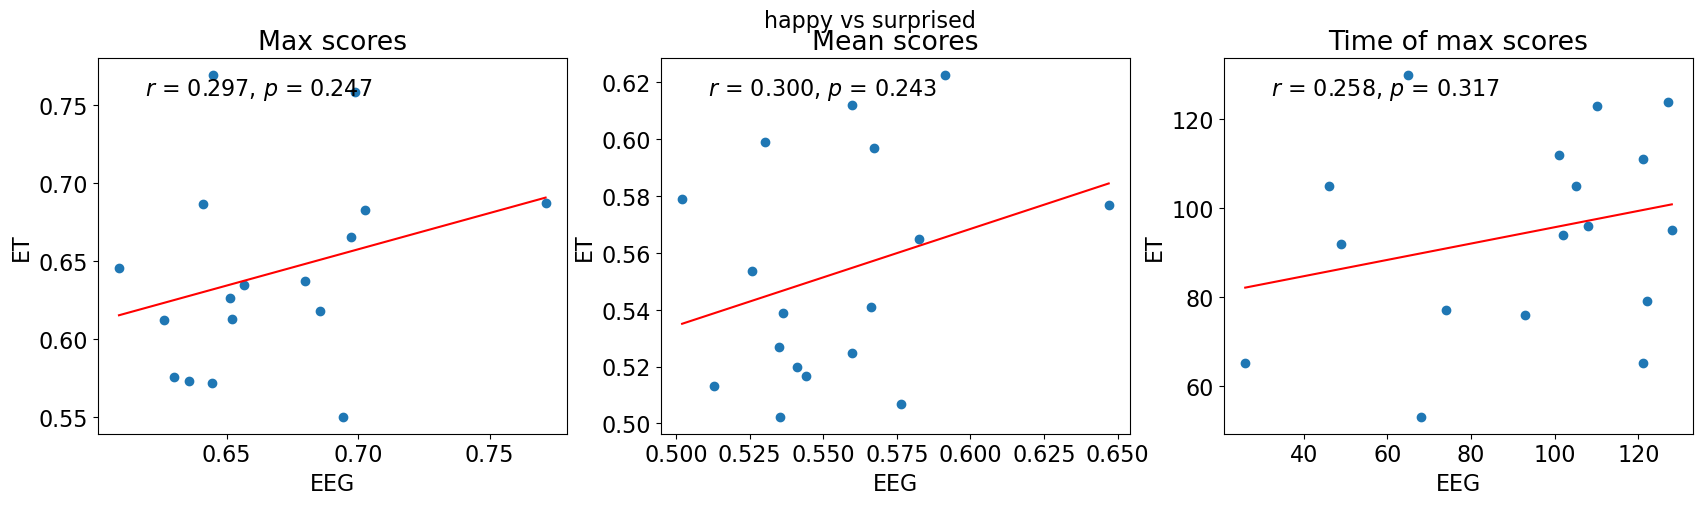

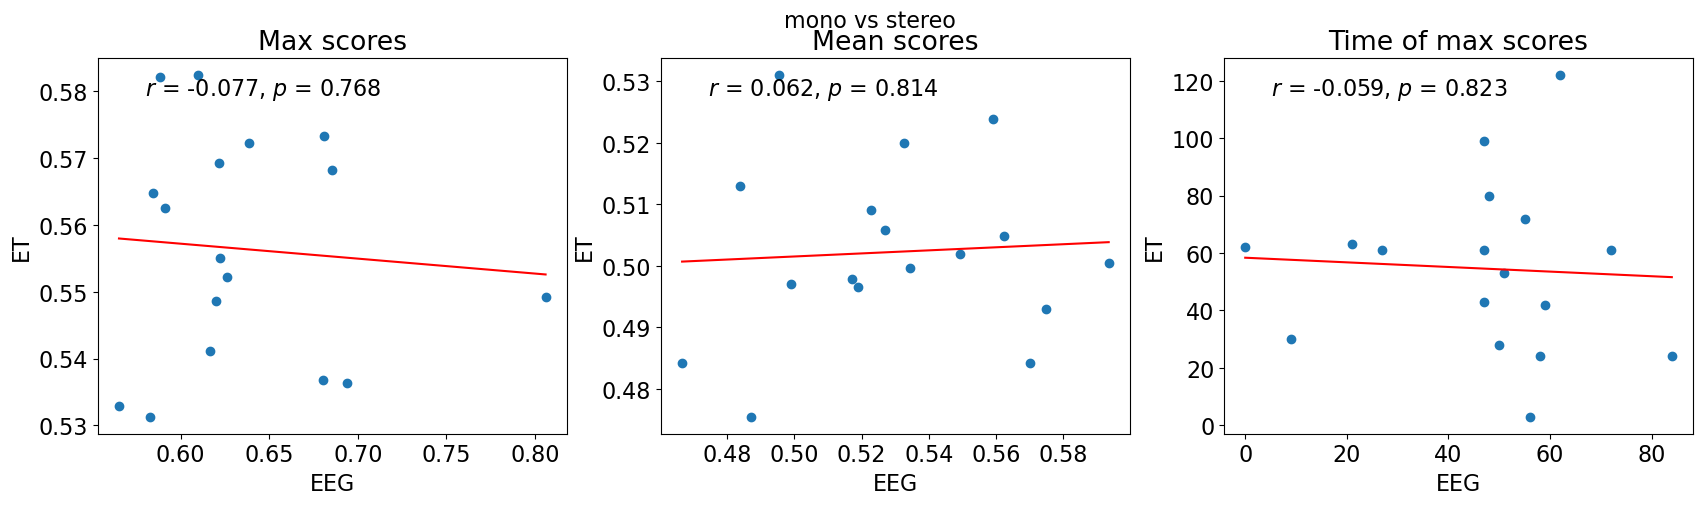

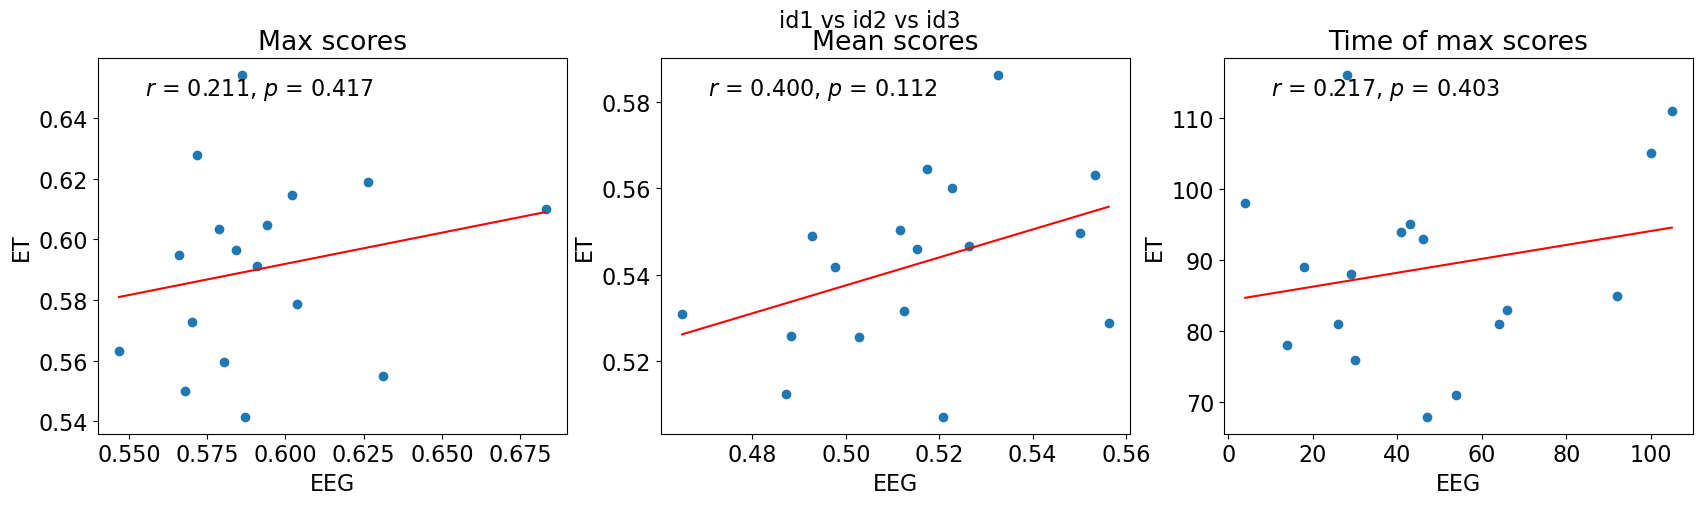

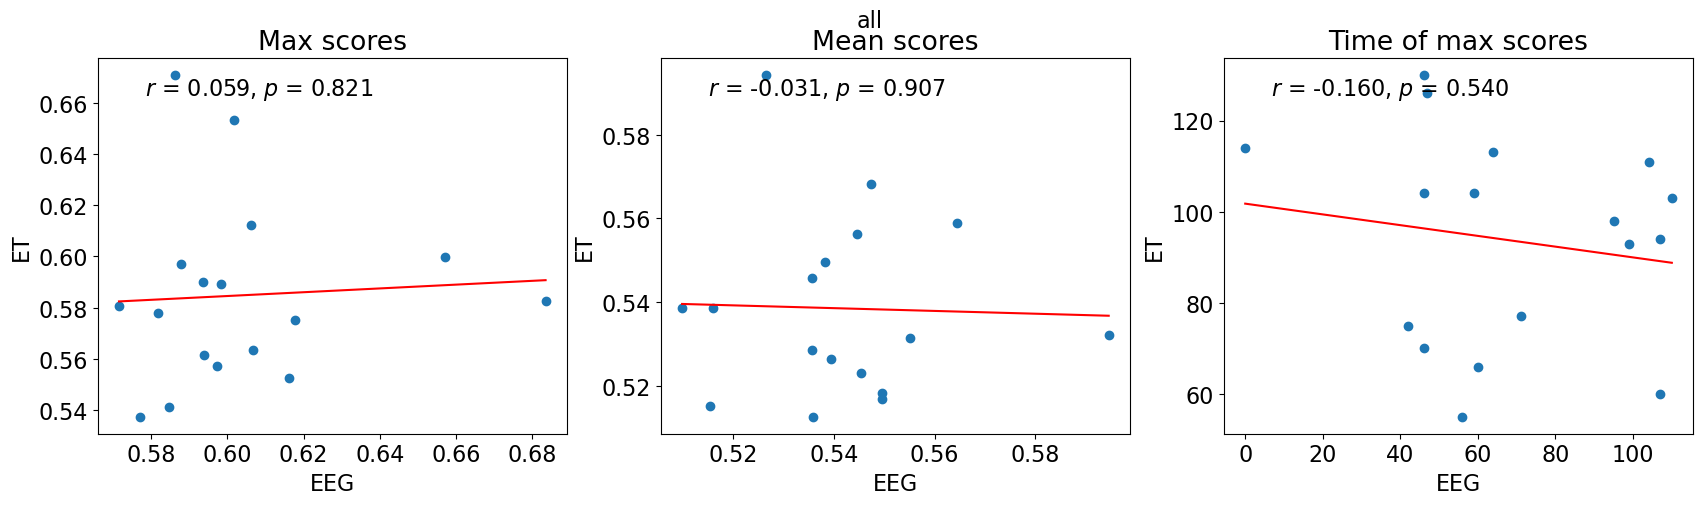

In [53]:
for c in data_dict_allcontrasts_et:
  d_eeg = data_dict_allcontrasts_eeg[c]["scores"]
  d_et = data_dict_allcontrasts_et[c]["scores"]
  eeg_max = d_eeg.max(axis=1)
  et_max = d_et.max(axis=1)

  eeg_mean = d_eeg[:,np.where(times_eeg > 0.0)].squeeze().mean(axis=1)
  et_mean = d_et[:,np.where(times_eeg > 0.0)].squeeze().mean(axis=1)

  eeg_max_t = d_eeg.argmax(axis=1)
  et_max_t = d_et.argmax(axis=1)

  fig, ax = plt.subplots(1, 3, figsize=(6 * 8.7152 * cm, 2 * 6.1993 * cm))
  fig.suptitle(c.replace("_vs_", " vs "), fontsize=16)
  plot_corr(eeg_max, et_max, "Max scores", ax=ax[0])
  plot_corr(eeg_mean, et_mean, "Mean scores", ax=ax[1])
  plot_corr(eeg_max_t, et_max_t, "Time of max scores", ax=ax[2])

In [46]:
def plot_corr(d_eeg, d_et, title="", ax=None, contrast=""):
  corr, p = stats.pearsonr(d_eeg, d_et)
  print(f"Correlation between {title} scores of EEG and ET: {corr:.3f}, p = {p:.3f}")
  ax.scatter(d_eeg, d_et)
  # add correlation line
  ax.plot(np.unique(d_eeg), np.poly1d(np.polyfit(d_eeg, d_et, 1))(np.unique(d_eeg)), color="red")
  ax.set_xlabel("EEG")
  ax.set_ylabel("ET")
  ax.set_title(title)
  # add correlation stats as text to plot
  ax.text(0.1, 0.9, f"$r$ = {corr:.3f}, $p$ = {p:.3f}", transform=ax.transAxes)

In [185]:
mystr = "haha_ff"
mystr.replace("_", " ")

'haha ff'

Correlation between Peak score scores of EEG and ET: -0.040, p = 0.878
Correlation between Mean score scores of EEG and ET: -0.012, p = 0.965
Correlation between Peak time scores of EEG and ET: 0.035, p = 0.894


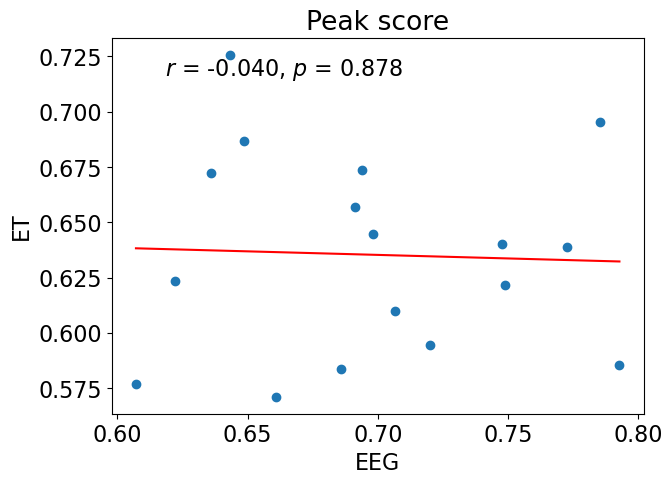

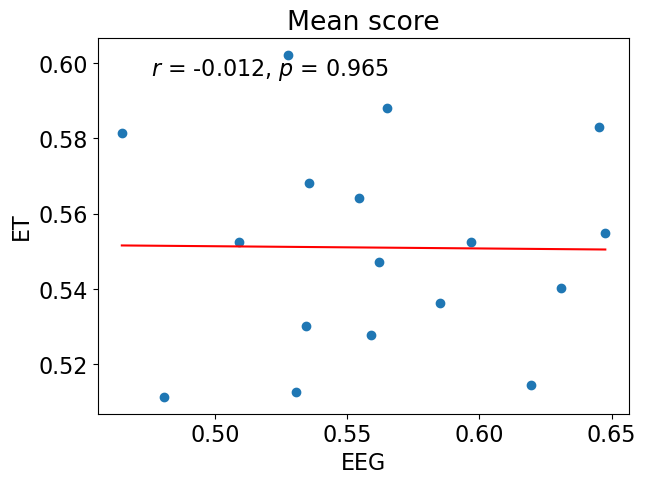

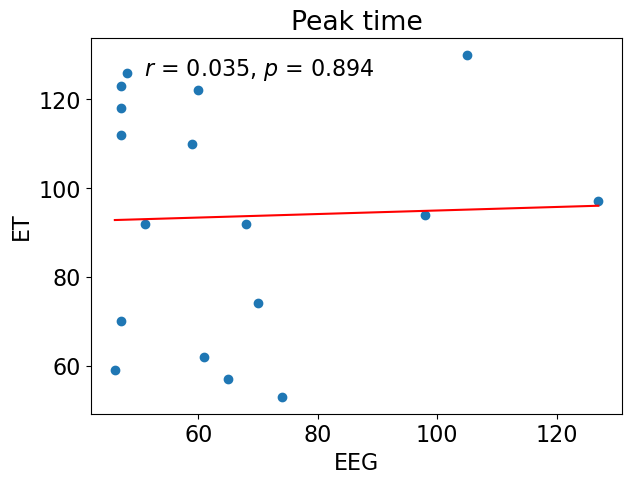

In [78]:
eeg_max = d_eeg.max(axis=1)
et_max = d_et.max(axis=1)

eeg_mean = d_eeg[:,np.where(times_eeg > 0.0)].squeeze().mean(axis=1)
et_mean = d_et[:,np.where(times_eeg > 0.0)].squeeze().mean(axis=1)

eeg_max_t = d_eeg.argmax(axis=1)
et_max_t = d_et.argmax(axis=1)

fig, ax = plt.subplots(1, figsize=(2*8.7152 * cm, 2*6.1993 * cm))
plot_corr(eeg_max, et_max, ax=ax, title="Peak score")
fig, ax = plt.subplots(1, figsize=(2*8.7152 * cm, 2*6.1993 * cm))
plot_corr(eeg_mean, et_mean, ax=ax, title="Mean score")
fig, ax = plt.subplots(1, figsize=(2*8.7152 * cm, 2*6.1993 * cm))
plot_corr(eeg_max_t, et_max_t, title="Peak time", ax=ax)




# Analysis on time windows (rmANOVA)

In [20]:


df_all = pd.DataFrame()
timings = TIMINGS()
erp_windows = timings.ERP_WINDOWS

binary_contrasts = [("angry", "neutral"),
                    ("angry", "happy"),
                    ("angry", "surprised"),
                    ("happy", "neutral"),
                    ("happy", "surprised"),
                    ("surprised", "neutral")]

for c in binary_contrasts:
    data_dict_na = load_decod_res_per_viewcond(
        sub_list_str=sub_list_str,
        conditions=list(c),
        vc_list=[""],
        scoring="roc_auc_ovr",
    )
    if "" in data_dict_na:
        data_dict_na["all"] = data_dict_na.pop("")

    for tw in erp_windows:
        df_tmp = pd.DataFrame()
        tmin, tmax = erp_windows[tw]
        tidx = np.logical_and(data_dict_na["all"]["times"] >= tmin,
                              data_dict_na["all"]["times"] <= tmax)
        tmp_data = data_dict_na["all"]["scores"]
        tmp_data_tw = tmp_data[:, tidx].mean(axis=1).squeeze()
        df_tmp["score"] = tmp_data_tw
        df_tmp["time_win"] = tw
        df_tmp["contrast"] = "_vs_".join(c)
        df_tmp["sub_id"] = sub_list_str
        df_all = pd.concat([df_all, df_tmp]) if df_all.size else df_tmp

print(AnovaRM(df_all,
            depvar = "score",
            subject = "sub_id",
            within = ["time_win", "contrast"]).fit())

                      Anova
                  F Value  Num DF  Den DF  Pr > F
-------------------------------------------------
time_win          29.6957  3.0000  48.0000 0.0000
contrast           3.1226  5.0000  80.0000 0.0126
time_win:contrast  1.4999 15.0000 240.0000 0.1057



In [15]:
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

df_posthoc_tw = (df_all
                    .groupby(["time_win", "sub_id"])
                    .agg({"score": "mean"})
                    .reset_index()
)


time_wins = list(erp_windows.keys())
pairwise_comps = [(time_wins[i], time_wins[j]) for i in range(len(time_wins))
                                            for j in range(len(time_wins)) if i < j]

posthoc_results = {}
for tw1, tw2 in pairwise_comps:
    t_stat, p_val = ttest_rel(df_posthoc_tw.query("time_win == @tw1")["score"],
                            df_posthoc_tw.query("time_win == @tw2")["score"])
    posthoc_results[f"{tw1} vs {tw2}"] = (t_stat, p_val)

p_vals = [p for _, p in posthoc_results.values()]
_, p_adj, _, _ = multipletests(p_vals, method="bonferroni")
for i, key in enumerate(posthoc_results):
    print(f"{key}: t = {posthoc_results[key][0]:.2f}, p = {p_adj[i]:.3f}")


P1 vs N170: t = 0.45, p = 1.000
P1 vs EPN: t = -3.71, p = 0.011
P1 vs LPC: t = -8.09, p = 0.000
N170 vs EPN: t = -3.85, p = 0.008
N170 vs LPC: t = -8.15, p = 0.000
EPN vs LPC: t = -3.27, p = 0.029


## Post-hoc tests effect `contrast`

In [27]:
df_posthoc_c = (df_all
                    .groupby(["contrast", "sub_id"])
                    .agg({"score": "mean"})
                    .reset_index()
)


binary_contrasts_str = ["_vs_".join(c) for c in binary_contrasts]
pairwise_comps = [(binary_contrasts_str[i], binary_contrasts_str[j])
                  for i in range(len(binary_contrasts_str))
                  for j in range(len(binary_contrasts_str)) if i < j]

posthoc_results = {}
for c1, c2 in pairwise_comps:
    t_stat, p_val = ttest_rel(df_posthoc_c.query("contrast == @c1")["score"],
                            df_posthoc_c.query("contrast == @c2")["score"])
    posthoc_results[f"{c1} vs {c2}"] = (t_stat, p_val)

p_vals = [p for _, p in posthoc_results.values()]
_, p_adj, _, _ = multipletests(p_vals, method="bonferroni")
for i, key in enumerate(posthoc_results):
    print(f"{key}: t = {posthoc_results[key][0]:.2f}, p = {p_adj[i]:.3f}")

angry_vs_neutral vs angry_vs_happy: t = -1.52, p = 1.000
angry_vs_neutral vs angry_vs_surprised: t = 2.10, p = 0.784
angry_vs_neutral vs happy_vs_neutral: t = 1.31, p = 1.000
angry_vs_neutral vs happy_vs_surprised: t = 0.45, p = 1.000
angry_vs_neutral vs surprised_vs_neutral: t = -0.04, p = 1.000
angry_vs_happy vs angry_vs_surprised: t = 2.96, p = 0.139
angry_vs_happy vs happy_vs_neutral: t = 3.13, p = 0.098
angry_vs_happy vs happy_vs_surprised: t = 2.70, p = 0.238
angry_vs_happy vs surprised_vs_neutral: t = 1.07, p = 1.000
angry_vs_surprised vs happy_vs_neutral: t = -0.89, p = 1.000
angry_vs_surprised vs happy_vs_surprised: t = -1.65, p = 1.000
angry_vs_surprised vs surprised_vs_neutral: t = -2.49, p = 0.360
happy_vs_neutral vs happy_vs_surprised: t = -0.95, p = 1.000
happy_vs_neutral vs surprised_vs_neutral: t = -1.20, p = 1.000
happy_vs_surprised vs surprised_vs_neutral: t = -0.46, p = 1.000


In [32]:
from scipy.stats import ttest_1samp

colors = COLORS()
df_posthoc_chance = pd.DataFrame()

for time_win in time_wins:  # noqa: B007
  # Post-hoc pairwise t-tests for binary emotion contrasts:
  df_posthoc = (df_all
                  .query("time_win == @time_win")
                  .groupby(["sub_id", "contrast"])
                  .agg({"score": "mean", "contrast": "first"})
                  .reset_index(drop=True)
  )

  binary_contrasts_str = ["_vs_".join(c) for c in binary_contrasts]
  pairwise_comps = [(binary_contrasts_str[i], binary_contrasts_str[j])
                    for i in range(len(binary_contrasts_str))
                    for j in range(len(binary_contrasts_str)) if i < j]

  posthoc_results = {}
  for c1, c2 in pairwise_comps:
    t_stat, p_val = ttest_rel(df_posthoc.query("contrast == @c1")["score"],
                              df_posthoc.query("contrast == @c2")["score"])
    posthoc_results[f"{c1} vs {c2}"] = (t_stat, p_val)

  p_vals = [p for _, p in posthoc_results.values()] * len(time_wins)
  _, p_adj, _, _ = multipletests(p_vals, method="bonferroni")
  p_adj = p_adj[:len(posthoc_results)]

  print(f"\nTime window: {time_win}")
  for i, key in enumerate(posthoc_results):
    if p_adj[i] < 0.05:
      print(f"{key}: t = {posthoc_results[key][0]:.2f}, p = {p_adj[i]:.3f}")

  print("\nContrasts vs chance:")
  posthoc_results = {}
  for c in binary_contrasts_str:
    t_stat, p_val = ttest_1samp(df_posthoc.query("contrast == @c")["score"],
                              0.5)
    posthoc_results[c] = (t_stat, p_val)
  
  p_vals = [p for _, p in posthoc_results.values()] * len(time_wins)
  _, p_adj, _, _ = multipletests(p_vals, method="bonferroni")
  p_adj = p_adj[:len(posthoc_results)]

  for i, c in enumerate(posthoc_results):
    if p_adj[i] < 0.05:
      print(f"{c} vs chance: t = {posthoc_results[c][0]:.2f}, p = {p_adj[i]:.5f}")
    
    df_ttmp = pd.DataFrame({"contrast": c,
                              "time_win": time_win,
                              "p_val": p_adj[i],
                              "sign": p_adj[i] < 0.05},
                              index=[0])
    df_posthoc_chance = pd.concat([df_posthoc_chance, df_ttmp]) if df_posthoc_chance.size else df_ttmp
  if not any(df_posthoc_chance["sign"]):
    print("No significant differences found.")



Time window: P1

Contrasts vs chance:
No significant differences found.

Time window: N170

Contrasts vs chance:
No significant differences found.

Time window: EPN

Contrasts vs chance:
No significant differences found.

Time window: LPC

Contrasts vs chance:
angry_vs_neutral vs chance: t = 7.97, p = 0.00001
angry_vs_happy vs chance: t = 4.95, p = 0.00348
happy_vs_surprised vs chance: t = 5.51, p = 0.00114
surprised_vs_neutral vs chance: t = 5.17, p = 0.00224


(0.4, 0.75)

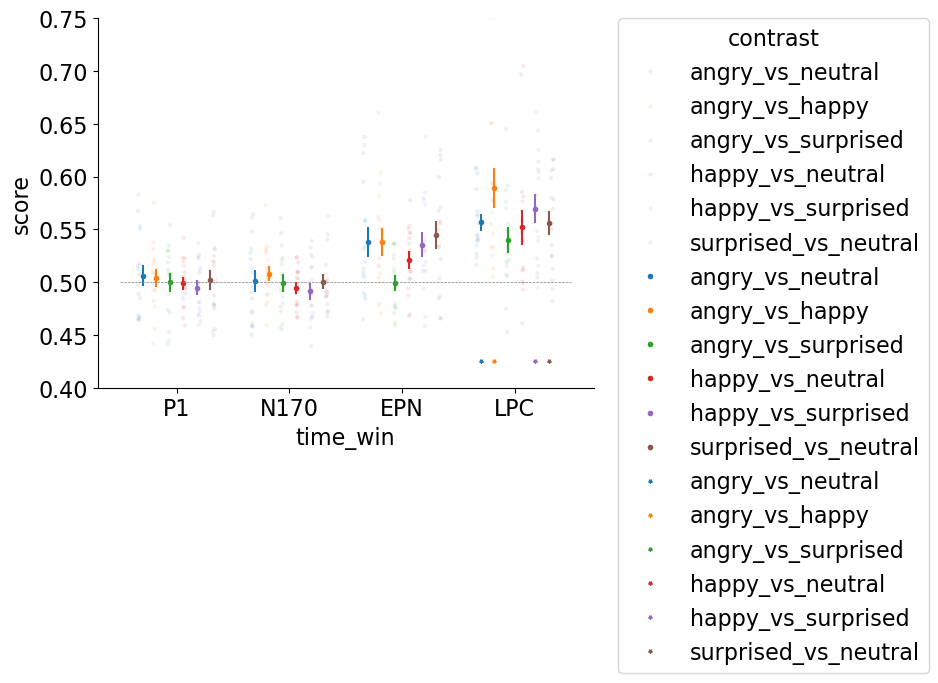

In [33]:

o = sns.stripplot(data=df_all, x="time_win", y="score", hue="contrast", dodge=True,
                  size=3, jitter=0.075,
                  alpha=0.1)
o = sns.pointplot(
    data=df_all.reset_index(),
    x="time_win",
    y="score",
    hue="contrast",
    errorbar="se",
    dodge=0.6,
    #palette=colors.COLDICT,
    linestyles='None',
    markers="o",
    markersize=2,
    err_kws={'linewidth': 1.5},
    )

df_posthoc_chance["y"] = df_posthoc_chance.apply(lambda x: 0.425 if x["sign"] else -0.4, axis=1)

o = sns.pointplot(data=df_posthoc_chance, x="time_win", y="y",
                  hue="contrast", dodge=0.6, markers="*", markersize=2, linestyles="None")

sns.move_legend(o, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
o.hlines(0.5, -0.5, 3.5, linestyles="dashed", linewidth=0.5, color="grey")
o.set_ylim(0.4, 0.75)

## For the multiclass decoder

In [40]:
df_plt_mc = pd.DataFrame()

for vc in ["all", "mono", "stereo"]:

    print("\n\n========================================================"
           f"\n========================================================\nViewing condition: {vc}"
            "\n========================================================\n")

    tmp_data = data_dict_allemos[vc]["scores"]
    times = data_dict_allemos[vc]["times"]

    df_tmp = pd.DataFrame()

    for tw in erp_windows:
        tmin, tmax = erp_windows[tw]
        tidx = np.logical_and(times >= tmin,
                              times <= tmax)
        tmp_data_tw = tmp_data[:, tidx].mean(axis=1).squeeze()
        df_tmp[tw] = tmp_data_tw

    df_aov_tmp = pd.melt(df_tmp, var_name="time_win", value_name="score", ignore_index=False).reset_index(names="sub_id")
    print(AnovaRM(df_aov_tmp,
                depvar = "score",
                subject = "sub_id",
                within = ["time_win"]).fit())


    time_wins = list(erp_windows.keys())
    pairwise_comps = [(time_wins[i], time_wins[j]) for i in range(len(time_wins))
                                                for j in range(len(time_wins)) if i < j]

    posthoc_results = {}
    for tw1, tw2 in pairwise_comps:
        t_stat, p_val = ttest_rel(df_aov_tmp.query("time_win == @tw1")["score"],
                                df_aov_tmp.query("time_win == @tw2")["score"])
        posthoc_results[f"{tw1} vs {tw2}"] = (t_stat, p_val)

    p_vals = [p for _, p in posthoc_results.values()]
    _, p_adj, _, _ = multipletests(p_vals, method="bonferroni")
    for i, key in enumerate(posthoc_results):
        print(f"{key}: t = {posthoc_results[key][0]:.2f}, p = {p_adj[i]:.3f}")

    print("\nPerformance vs chance:")

    for tw in time_wins:
        t_stat, p_val = ttest_1samp(df_aov_tmp.query("time_win == @tw")["score"],
                                0.5)
        print(f"{tw} vs chance: t = {t_stat:.2f}, p = {p_val:.5f}")


    df_plt = (df_aov_tmp
            .assign(time_win = pd.Categorical(df_aov_tmp["time_win"], categories=time_wins, ordered=True))
            .sort_values(by=["time_win"])
            .reset_index(drop=True)
    )
    df_plt["viewcond"] = vc

    df_plt_mc = pd.concat([df_plt_mc, df_plt]) if df_plt_mc.size else df_plt





Viewing condition: all

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
time_win 26.7798 3.0000 48.0000 0.0000

P1 vs N170: t = 0.28, p = 1.000
P1 vs EPN: t = -3.86, p = 0.008
P1 vs LPC: t = -7.56, p = 0.000
N170 vs EPN: t = -4.06, p = 0.005
N170 vs LPC: t = -7.58, p = 0.000
EPN vs LPC: t = -2.74, p = 0.088

Performance vs chance:
P1 vs chance: t = -0.13, p = 0.90100
N170 vs chance: t = -0.37, p = 0.71442
EPN vs chance: t = 4.02, p = 0.00100
LPC vs chance: t = 7.93, p = 0.00000


Viewing condition: mono

                Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
time_win 15.0859 3.0000 48.0000 0.0000

P1 vs N170: t = 1.60, p = 0.770
P1 vs EPN: t = -3.02, p = 0.048
P1 vs LPC: t = -4.79, p = 0.001
N170 vs EPN: t = -4.12, p = 0.005
N170 vs LPC: t = -5.26, p = 0.000
EPN vs LPC: t = -1.49, p = 0.927

Performance vs chance:
P1 vs chance: t = 0.66, p = 0.51617
N170 vs chance: t = -0.82, p = 0.42256


In [44]:
def get_max_decod_score_and_time(data_dict):
  peak_mean = data_dict["scores"].max(axis=1).mean()
  peak_sd = data_dict["scores"].max(axis=1).std()
  peak_cil = peak_mean - 1.96 * peak_sd / np.sqrt(len(data_dict["scores"]))
  peak_ciu = peak_mean + 1.96 * peak_sd / np.sqrt(len(data_dict["scores"]))
  times = data_dict_allemos["all"]["times"]
  tidx = int(np.median(data_dict["scores"].argmax(axis=1)))
  peak_time = times[tidx] * 1000
  peak_time_sd = np.std(times[data_dict["scores"].argmax(axis=1)]) * 1000
  peak_time_cil = peak_time - 1.96 * peak_time_sd / np.sqrt(len(data_dict["scores"]))
  peak_time_ciu = peak_time + 1.96 * peak_time_sd / np.sqrt(len(data_dict["scores"]))
  print(f"Peak mean: M = {peak_mean:.2f}, SD = {peak_sd:.2f}, 95% CI [{peak_cil:.2f}, {peak_ciu:.2f}]")
  print(f"Peak time: M = {peak_time:.2f}, SD = {peak_time_sd:.2f}), 95% CI [{peak_time_cil:.2f}, {peak_time_ciu:.2f}]")
  return peak_mean, peak_sd, peak_cil, peak_ciu, peak_time, peak_time_sd, peak_time_cil, peak_time_ciu



def get_decod_df(data_dict):
  peaks = data_dict["scores"].max(axis=1)
  times = data_dict["times"]
  peak_times = times[data_dict["scores"].argmax(axis=1)] * 1000
  peak_df = pd.DataFrame({"peak": peaks, "peak_time": peak_times})
  return peak_df


def get_binary_results(data_dict_na, contrast_str):
      # print stats:
      print("\nMono:")
      res_mono  = get_max_decod_score_and_time(data_dict_na["mono"])
      print("\nStereo:")
      res_stereo = get_max_decod_score_and_time(data_dict_na["stereo"])

      dd = {("Mono", "Peak", "Mean"): res_mono[0],
            ("Mono", "Peak", "SD"): res_mono[1],
            ("Mono", "Peak", "cil"): res_mono[2],
            ("Mono", "Peak", "ciu"): res_mono[3],
            ("Mono", "Peak", "CI"): f"[{res_mono[2]:.2f}, {res_mono[3]:.2f}]",
            ("Mono", "Time", "Mean"): res_mono[4],
            ("Mono", "Time", "SD"): res_mono[5],
            ("Mono", "Time", "cil"): res_mono[6],
            ("Mono", "Time", "ciu"): res_mono[7],
            ("Mono", "Time", "CI"): f"[{res_mono[6]:.2f}, {res_mono[7]:.2f}]",
            ("Stereo", "Peak", "Mean"): res_stereo[0],
            ("Stereo", "Peak", "SD"): res_stereo[1],
            ("Stereo", "Peak", "cil"): res_stereo[2],
            ("Stereo", "Peak", "ciu"): res_stereo[3],
            ("Stereo", "Peak", "CI"): f"[{res_stereo[2]:.2f}, {res_stereo[3]:.2f}]",
            ("Stereo", "Time", "Mean"): res_stereo[4],
            ("Stereo", "Time", "SD"): res_stereo[5],
            ("Stereo", "Time", "cil"): res_stereo[6],
            ("Stereo", "Time", "ciu"): res_stereo[7],
            ("Stereo", "Time", "CI"): f"[{res_stereo[6]:.2f}, {res_stereo[7]:.2f}]",
            }

      # run paired t-test:
      df_mono = get_decod_df(data_dict_na["mono"])
      df_stereo = get_decod_df(data_dict_na["stereo"])
      ttest_res = stats.ttest_rel(df_mono["peak"], df_stereo["peak"])
      print("\nStats (mono vs stereo):")
      print(f"Peak stats (paired t test): t = {ttest_res.statistic:.2f}, p = {ttest_res.pvalue:.3f}")
      dd[("Stats", "Peak", f"t({ttest_res.df})")] = ttest_res.statistic
      dd[("Stats", "Peak", "p")] = ttest_res.pvalue

      ttest_res_time = stats.ttest_rel(df_mono["peak_time"], df_stereo["peak_time"])
      print(f"Peak time stats: t = {ttest_res_time.statistic:.2f}, p = {ttest_res_time.pvalue:.3f}")
      dd[("Stats", "Time", f"t({ttest_res_time.df})")] = ttest_res_time.statistic
      dd[("Stats", "Time", "p")] = ttest_res_time.pvalue

      del ttest_res, ttest_res_time, res_mono, res_stereo, df_mono, df_stereo

      df = pd.DataFrame(dd, index=[contrast_str])
      return df


def print_table_contrasts(variable="Peak"):
  binary_contrasts = [("angry", "neutral"),
                      ("angry", "happy"),
                      ("angry", "surprised"),
                      ("happy", "neutral"),
                      ("happy", "surprised"),
                      ("surprised", "neutral"),
                      ("id1", "id2", "id3")]

  mydf = pd.DataFrame()
  for c in binary_contrasts:
      print(f"\n\n\nContrast: {' vs '.join(c)}")
      data_dict_na = load_decod_res_per_viewcond(
              sub_list_str=sub_list_str,
              conditions=list(c),
              vc_list=["mono", "stereo"],
              scoring="roc_auc_ovr",
      )
      ddf = get_binary_results(data_dict_na, "  vs  ".join(c))
      mydf = pd.concat([mydf, ddf]) if mydf.size else ddf

  # Peak scores:
  idx = pd.IndexSlice
  peak_df = mydf.loc[:, idx[:, variable, :]]
  # remove useless level of the multiindex:
  peak_df.columns = peak_df.columns.droplevel(1)

  idx = pd.IndexSlice
  pval_cols = idx[:, idx[:,"p"]]
  sdf = peak_df.drop(columns=["cil", "ciu"], level=1) \
            .style \
            .set_table_styles([dict(selector="th", props=[("text-align", "center")])]) \
            .format(lambda x: f"{x:.2f}" if isinstance(x, float) else x) \
            .format("{:.3f}", subset=pval_cols)
  display(sdf)
  print(sdf.to_latex(multicol_align="c", hrules=True, column_format="lcccccccc"))



In [ ]:

  # Peak scores:
  idx = pd.IndexSlice
  peak_df = mydf.loc[:, idx[:, variable, :]]
  # remove useless level of the multiindex:
  peak_df.columns = peak_df.columns.droplevel(1)

  idx = pd.IndexSlice
  pval_cols = idx[:, idx[:,"p"]]
  sdf = peak_df.drop(columns=["cil", "ciu"], level=1) \
            .style \
            .set_table_styles([dict(selector="th", props=[("text-align", "center")])]) \
            .format(lambda x: f"{x:.2f}" if isinstance(x, float) else x) \
            .format("{:.3f}", subset=pval_cols)
  display(sdf)
  print(sdf.to_latex(multicol_align="c", hrules=True, column_format="lcccccccc"))


# Overall:
print("All:")
_ = get_max_decod_score_and_time(data_dict_allemos["all"])
# Mono:
print("\nMono:")
_ = get_max_decod_score_and_time(data_dict_allemos["mono"])
print("\nStereo:")
_ = get_max_decod_score_and_time(data_dict_allemos["stereo"])

# run paired t-test:
df_mono = get_decod_df(data_dict_allemos["mono"])
df_stereo = get_decod_df(data_dict_allemos["stereo"])
t_peak_results = stats.ttest_rel(df_mono["peak"], df_stereo["peak"])
t_peak = t_peak_results.statistic
p_peak = t_peak_results.pvalue
df_peak = t_peak_results.df
print("\nStats (mono vs stereo):")
print(f"Peak stats (paired t test): t({df_peak}) = {t_peak:.2f}, p = {p_peak:.3f}")
t_peak_time_results = stats.ttest_rel(df_mono["peak_time"], df_stereo["peak_time"])
print(f"Peak time stats: t({t_peak_time_results.df}) = {t_peak_time_results.statistic:.2f}, p = {t_peak_time_results.pvalue:.3f}")

In [45]:
# All binary contrasts:

print_table_contrasts("Peak")
print_table_contrasts("Time")




Contrast: angry vs neutral

Mono:
Peak mean: M = 0.66, SD = 0.05, 95% CI [0.64, 0.69]
Peak time: M = 433.33, SD = 363.69), 95% CI [260.45, 606.22]

Stereo:
Peak mean: M = 0.65, SD = 0.03, 95% CI [0.63, 0.66]
Peak time: M = 616.67, SD = 352.95), 95% CI [448.88, 784.45]

Stats (mono vs stereo):
Peak stats (paired t test): t = 2.04, p = 0.058
Peak time stats: t = -1.19, p = 0.250



Contrast: angry vs happy

Mono:
Peak mean: M = 0.69, SD = 0.09, 95% CI [0.65, 0.73]
Peak time: M = 716.67, SD = 276.30), 95% CI [585.32, 848.01]

Stereo:
Peak mean: M = 0.68, SD = 0.08, 95% CI [0.64, 0.72]
Peak time: M = 633.33, SD = 282.01), 95% CI [499.28, 767.39]

Stats (mono vs stereo):
Peak stats (paired t test): t = 1.26, p = 0.227
Peak time stats: t = 0.16, p = 0.877



Contrast: angry vs surprised

Mono:
Peak mean: M = 0.64, SD = 0.04, 95% CI [0.62, 0.66]
Peak time: M = 633.33, SD = 416.62), 95% CI [435.29, 831.38]

Stereo:
Peak mean: M = 0.63, SD = 0.03, 95% CI [0.62, 0.65]
Peak time: M = 516.67, S

\begin{table}
\thcenter
\begin{tabular}{lcccccccc}
\toprule
 & \multicolumn{3}{c}{Mono} & \multicolumn{3}{c}{Stereo} & \multicolumn{2}{c}{Stats} \\
 & Mean & SD & CI & Mean & SD & CI & t(16) & p \\
\midrule
angry  vs  neutral & 0.66 & 0.05 & [0.64, 0.69] & 0.65 & 0.03 & [0.63, 0.66] & 2.04 & 0.058 \\
angry  vs  happy & 0.69 & 0.09 & [0.65, 0.73] & 0.68 & 0.08 & [0.64, 0.72] & 1.26 & 0.227 \\
angry  vs  surprised & 0.64 & 0.04 & [0.62, 0.66] & 0.63 & 0.03 & [0.62, 0.65] & 0.43 & 0.670 \\
happy  vs  neutral & 0.65 & 0.06 & [0.62, 0.67] & 0.64 & 0.05 & [0.62, 0.66] & 1.12 & 0.279 \\
happy  vs  surprised & 0.66 & 0.05 & [0.64, 0.68] & 0.66 & 0.05 & [0.63, 0.68] & -0.23 & 0.823 \\
surprised  vs  neutral & 0.64 & 0.03 & [0.62, 0.65] & 0.63 & 0.03 & [0.62, 0.65] & 0.18 & 0.857 \\
id1  vs  id2  vs  id3 & 0.60 & 0.03 & [0.58, 0.61] & 0.60 & 0.03 & [0.58, 0.61] & -0.53 & 0.601 \\
\bottomrule
\end{tabular}
\end{table}




Contrast: angry vs neutral

Mono:
Peak mean: M = 0.66, SD = 0.05, 95% CI [0

\begin{table}
\thcenter
\begin{tabular}{lcccccccc}
\toprule
 & \multicolumn{3}{c}{Mono} & \multicolumn{3}{c}{Stereo} & \multicolumn{2}{c}{Stats} \\
 & Mean & SD & CI & Mean & SD & CI & t(16) & p \\
\midrule
angry  vs  neutral & 433.33 & 363.69 & [260.45, 606.22] & 616.67 & 352.95 & [448.88, 784.45] & -1.19 & 0.250 \\
angry  vs  happy & 716.67 & 276.30 & [585.32, 848.01] & 633.33 & 282.01 & [499.28, 767.39] & 0.16 & 0.877 \\
angry  vs  surprised & 633.33 & 416.62 & [435.29, 831.38] & 516.67 & 419.97 & [317.03, 716.31] & 0.37 & 0.718 \\
happy  vs  neutral & 550.00 & 390.17 & [364.53, 735.47] & 633.33 & 438.44 & [424.91, 841.76] & 0.27 & 0.788 \\
happy  vs  surprised & 483.33 & 391.59 & [297.18, 669.48] & 658.33 & 245.01 & [541.86, 774.81] & -1.19 & 0.251 \\
surprised  vs  neutral & 416.67 & 266.03 & [290.20, 543.13] & 458.33 & 327.14 & [302.82, 613.84] & -0.19 & 0.852 \\
id1  vs  id2  vs  id3 & 550.00 & 231.29 & [440.05, 659.95] & 500.00 & 349.07 & [334.06, 665.94] & 0.82 & 0.425 \\
\bot